In [1]:
# Parameters
attr_path = "/srv/stemly/data/7/index/3/attributes/attributes.csv"
index_path = "/srv/stemly/data/7/index/3/index/index.csv"
committed_files = ["/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1661315396541.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662444054358.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662553683649.parquet"]
predict_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.predict.latest.parquet"
test_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.test.latest.parquet"
validate_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.validate.latest.parquet"
model = "custom"
model_file_id = "32"
model_resolution = None
reference_resolution = "MS"
project_offset = 1
project_periods = 18
project_resolution = "MS"
ts_train_start = "2020-07-01 00:00:00"
ts_train_v_end = "2022-05-01 00:00:00"
ts_train_t_end = "2022-04-01 00:00:00"
ts_train_p_end = "2022-06-01 00:00:00"
ts_test_start = "2022-04-01 00:00:00"
ts_test_end = "2022-05-01 00:00:00"
ts_test_duration = 1
ts_validate_start = "2022-05-01 00:00:00"
ts_validate_end = "2022-06-01 00:00:00"
ts_validate_duration = 1
ts_predict_start = "2022-06-01 00:00:00"
ts_predict_end = "2023-12-01 00:00:00"
ts_predict_duration = 18
redis_url = "redis://127.0.0.1:6300"
job_id = "6bf40e7f-aced-40f7-86fe-f49f8d23b343"
job_user_id = "3"
resource_id = "16"
resource_version = 1661403479559
resource_type = "modelbase"
workspace_id = "7"
job_name = "custom"
job_triggered_at = "2022-08-25 04:58:00"
job_triggered_by = "Mallikarjuna Reddy Padigapati"


price_file_paths = ["_input_data/price_df.parquet"]

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from pg_features import get_features,get_events
from pg_model import NAIFCModel
from utils import get_dates, calc_metrics, install_old_pandas, upgrade_pandas

import seaborn as sns
from datetime import timedelta
import os
import write_data_table
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
workspace = 'w' + workspace_id
verbose = True

In [4]:
main_group_index = ['sku', 'customer', 'warehouse']
mat_group = 'sku'
freq = "MS"
load_data_from_local = False
export_data = True

In [5]:
price_index = 1103

In [6]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [7]:
if load_data_from_local :
    price_var = 'price'
    volume_var = 'dc_offtake'
    main_group_index = ['sku', 'customer', 'warehouse']
    mat_group = 'sku'
else :
    price_var = 'y'
    volume_var = 'y'
    main_group_index = ['id']
    mat_group = 'sku'

In [8]:
joining_keys = ["ts"] + main_group_index
joining_keys

['ts', 'id']

## Helper

In [9]:
def get_results(predict_df, all_dates):
    results = pd.DataFrame()
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id)].reset_index(
            drop=True)
        test = ts.loc[ts.ts.isin(all_dates["test"])].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "test_start": all_dates["test"][0],
            "test_end": all_dates["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

    main_cols = ["id", "test_start", "test_end", "total_actual", "total_forecast"]
    results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
    results["mad"] = np.abs(results["total_actual"] - results["total_forecast"])
    results["model"] = predict_df.model[0]

    return results

## Dates

## Load data

In [10]:
price_index = 1103

In [11]:
if load_data_from_local :
    att_df = pd.read_csv("../../Cleaned_Input/all_att_data.csv")
    vol_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_volume.parquet")
    price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    list_price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    
    vol_df.rename(columns={'date':'ts'},inplace=True)
    price_df.rename(columns={'date':'ts'},inplace=True)
    list_price_df.rename(columns={'date':'ts'},inplace=True)

if not load_data_from_local:
    path_index_val = os.listdir("/srv/stemly/data/{}/index".format(workspace_id))[0]
    path_index = "/srv/stemly/data/{}/index".format(workspace_id) + "/" + str(path_index_val)
    vol_df = pd.concat([pd.read_parquet(fp) for fp in committed_files])

    att_df = pd.read_csv(attr_path)
    price_parquet_file_path = path_index + "/timeseries/"+ str(price_index)+ "/commit/ts.0"
    price_file_names =  os.listdir(price_parquet_file_path)
    price_file_paths = [price_parquet_file_path+ "/" + i for i in price_file_names]
    print(price_file_paths)

    price_df = pd.concat([pd.read_parquet(fp) for fp in price_file_paths])


['/srv/stemly/data/7/index/3/timeseries/1103/commit/ts.0/13.1661315396541.parquet']


In [12]:
sub_group_index = ['ts','sku','customer']
att_df_sub = att_df[[ 'sku', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku_description', 'cases','uom']].drop_duplicates()


In [13]:
vol_df.rename(columns={volume_var:'y'},inplace=True)
price_df.rename(columns={price_var:'price'},inplace=True)

price_df = price_df[main_group_index+['price','ts']]
vol_df = vol_df[main_group_index+['y','ts']]

vol_df = vol_df.groupby(joining_keys).sum().reset_index()
price_df = price_df.groupby(joining_keys).mean().reset_index()
if not load_data_from_local:
    att_df.rename(columns={'__idx':'id'},inplace=True)

print(vol_df.shape)
df_base = pd.merge(vol_df, price_df, on =joining_keys, how='left')
df_base = pd.merge(df_base, att_df,  on = main_group_index, how='left')
df_base
df_base.loc[df_base['y'] < 0,'y'] = 0
print(df_base.shape)

df_sub = df_base[['ts','sku','customer','y','price']]
df_sub1 = df_sub.groupby(sub_group_index).agg({'y':'sum','price':'mean'}).reset_index()
df_sub1 = pd.merge(df_sub1,att_df_sub,on=['sku','customer'],how='left')
df_sub1['price'].replace([np.inf,0, -np.inf],np.nan,inplace=True)
df_sub1['price'] = df_sub1.groupby(sub_group_index)['price'].transform(lambda x: x.ffill())
df_sub1['price'] = df_sub1.groupby(sub_group_index)['price'].transform(lambda x: x.bfill())
df_sub1['price'].replace([np.nan],0,inplace=True)

df_main = df_sub1.copy()
df_sub1.head()


(2409, 3)
(2409, 14)


ts           sku customer      y       price    item_type  material     ph_level2 ph_level3                           sku_description  cases uom
0 2020-07-01  815517026005    TMALL   49.0  263.877508        Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G
1 2020-07-01  815517026012    TMALL  164.0   73.642051        Cream  82314747  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 TUB JUL20     24   G
2 2020-07-01  815517026029    TMALL    0.0  119.281356        Cream  82314725          Face       FAB   FAB CRM GRAPEFRUIT 2.0OZ 56.7GX24 SEP20     25   G
3 2020-07-01  815517026036    TMALL  614.0  112.946006        Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20     24   G
4 2020-07-01  815517026043    TMALL    0.0  206.766623  Moisturizer  82314723  Ultra Repair       FAB  FAB UTRP MOISTURIZER 1.7OZ 50MLX24 SEP20     24  ML

In [14]:
df_main[ (df_main['sku'] == 815517026005) & (df_main['customer'] == 'TMALL') & (df_main['ts'] >= '2022-05-01')
        & (df_main['ts'] <= '2022-06-01')]

ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom
477 2022-05-01  815517026005    TMALL  2179.0  261.204416     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G
527 2022-06-01  815517026005    TMALL  2176.0  240.064605     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G

In [15]:
from dateutil.relativedelta import relativedelta
def generate_dates_new(
        last_test_date="2021-12-27",
        gap_in_days=28,
        test_horizon_in_days=28,
        version_skip = 28,
        fc_horizon_in_days=84,
        freq="W-Mon",
        n_rounds=2
):
    ts_test_end = pd.to_datetime(last_test_date) 
    ts_test_start = ts_test_end - pd.Timedelta(days=test_horizon_in_days - 1)
   
    ts_predict_start = ts_test_end + pd.Timedelta(days=1)
    ts_predict_end = ts_predict_start + pd.Timedelta(days=fc_horizon_in_days-1)

   
    test_dates = pd.date_range(
        start=ts_test_start,
        end=ts_test_end,
        freq=freq,
    )
    forecast_dates = pd.date_range(
        start=ts_predict_start,
        end=ts_predict_end,
        freq=freq,
    )
    a = test_dates[0].month
    all_dates_new = {
        a: {
            "test": test_dates,
            "forecast": forecast_dates,
        },
    }
    for k in range(n_rounds):
        a = a - 1
        if a == 0:
            a = 12
        test_dates = pd.date_range(
            start=test_dates[0]- relativedelta(months=version_skip),
            end=test_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        forecast_dates = pd.date_range(
            start=forecast_dates[0]- relativedelta(months=version_skip),
            end=forecast_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        all_dates_new.update({
            a: {
                "test": test_dates,
                "forecast": forecast_dates,
            }
        })
    return all_dates_new


In [16]:
ts_test_end = "2022-08-01 00:00:00"
all_dates = generate_dates_new(
#     last_test_date="2021-12-27",
    last_test_date= ts_test_end,
    freq=freq,
    gap_in_days=30,
    version_skip = 1,
    fc_horizon_in_days = 367,
    test_horizon_in_days=30,
    n_rounds=2
)
all_dates

versions = []
for i in all_dates.keys():
    versions.append(i)
m=list(all_dates.keys())[0]
    
versions ,all_dates 

([8, 7, 6],
 {8: {'test': DatetimeIndex(['2022-08-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01'], dtype='datetime64[ns]', freq='MS')},
  7: {'test': DatetimeIndex(['2022-07-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01'], dtype='datetime64[ns]', freq='MS')},
  6: {'test': DatetimeIndex(['2022-06-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'], dtype='datetime64[ns]', freq='MS')}})

In [17]:
data = df_main.copy()
data.head()

unique_id = data[['sku','customer']].drop_duplicates().reset_index(drop=True)
unique_id['id'] = unique_id.index
data = pd.merge(data,unique_id,on=['sku','customer'])
data.head()



def to_days(x):
    switcher = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    return switcher.get(x)
def week_of_month(date_value):
    return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
data["month"] = data["ts"].dt.month 
data["year"] = data["ts"].dt.year 

print(data.shape)
print(data.columns)
id_sales_train = data[data['ts'] <= all_dates[m]['test'][0]]
id_sales_train = id_sales_train.groupby('id')['y'].sum().reset_index()
id_with_sales_df = id_sales_train[id_sales_train['y'] > 0]
id_with_sales = id_with_sales_df.id.unique()
data = data[(data['id'].isin(id_with_sales))]
print(data.shape)
data.head()

(675, 15)
Index(['ts', 'sku', 'customer', 'y', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'id', 'month', 'year'], dtype='object')
(675, 15)


ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  id  month  year
0 2020-07-01  815517026005    TMALL    49.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      7  2020
1 2020-08-01  815517026005    TMALL  1501.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      8  2020
2 2020-09-01  815517026005    TMALL   103.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      9  2020
3 2020-10-01  815517026005    TMALL  6780.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     10  2020
4 2020-11-01  815517026005    TMALL  3996.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     11  2020

## Features

In [18]:
gap = len(all_dates[m]["test"])
window = 4

In [19]:
df = data.copy()
df =  df[df['customer'] == 'TMALL']

In [20]:
features_dfs = {}
for i in all_dates.keys():
    features_df = get_features(
        df.loc[df.ts <= all_dates[i]["test"].max()],
        all_dates[i],
        fill_with_nan=False,
        freq=freq,
        gap=gap,
        window=window,
        n_jobs=-1,
        use_val=False,
    )
    features_dfs.update({i: features_df})


Resampling
(409, 15)
Make future
(625, 15)
Create days features
(625, 22)
Create tsfresh
Create summary features
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku', 'sku_percent'], dtype='object')
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sk

In [21]:
ts_cols = ["id", "ts", "y"]
original_features = ["sku", "customer", 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', "price"]
dates_features = ["year", "month", "quarter", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
lag_features = [x for x in features_dfs[m].columns if "y_lag_" in x]
total_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features).columns[-60:]]
tsfresh_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features+total_features).columns]

In [22]:
tsfresh_features


[]

In [23]:
features_dfs[m].columns

Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku', 'sku_percent', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month', 'sku_month_percent'], dtype='object')

In [24]:
features_dfs[m].to_csv("op/sss.csv")

## Model 1 Cluster

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features_dfs[m] = features_dfs[m].drop(axis=1, labels=total_features)
features_dfs[m] = features_dfs[m].drop(axis=1, labels=tsfresh_features)

In [71]:
drop_cols1 = ['item_type', 'material',  'ph_level3', 'sku_description',  'cases', 'month',
               'uom',  'year', 'quarter', 'y_sum_sku', 'y_max_sku', 'y_min_sku', 
             'y_sum_sku_month',  'y_max_sku_month', 'y_min_sku_month', 'sku_month_percent', 
              'y_std_sku_month', 'is_month_start', 'is_month_end',  'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end' ]

In [72]:
features_dfs[m].drop(drop_cols1, axis=1, errors = 'ignore').columns

Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'ph_level2', 'y_mean_sku', 'y_std_sku', 'sku_percent', 'y_mean_sku_month'], dtype='object')

In [73]:
datas = {}
encoders = {}
for i in range(len(versions)):
    dates = all_dates[versions[i]]
    f = features_dfs[versions[i]].copy()
    f.drop(lag_features, axis=1, inplace=True)
    f.drop(drop_cols1, axis=1, inplace=True, errors = 'ignore')
    # get train, test, predict
    train = f.loc[f.ts < np.min(dates["test"])].reset_index(drop=True)
    test = f.loc[f.ts.isin(dates["test"])].reset_index(drop=True)
    predict = f.loc[f.ts.isin(dates["forecast"])].reset_index(drop=True)
    all_data = pd.concat([train, test]).reset_index(drop=True)

    train["y"] = train["y"].astype(float)
    test["y"] = test["y"].astype(float)
    predict["y"] = np.nan
    all_data["y"] = all_data["y"].astype(float)
    
    x_train, y_train = train.drop(columns=["y", "ts"]), train["y"]
    x_test, y_test = test.drop(columns=["y", "ts"]), test["y"]
    x_predict, y_predict = predict.drop(columns=["y", "ts"]), predict["y"]
    x_all, y_all = all_data.drop(columns=["y", "ts"]), all_data["y"]

    for c in x_train.select_dtypes(include=["number", "bool_"]).columns:
        x_train[c] = np.nan_to_num(x_train[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_test[c] = np.nan_to_num(x_test[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_predict[c] = np.nan_to_num(x_predict[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_all[c] = np.nan_to_num(x_all[c], nan=-9999, posinf=-9999, neginf=-9999)

    
    enc_cols = x_train.select_dtypes(exclude="number").columns.to_list()
    for col in enc_cols:
        enc = LabelEncoder()
        enc.fit(f[col])
        encoders.update({(versions[i], col): enc})
        x_train[col] = enc.transform(x_train[col])
        x_test[col] = enc.transform(x_test[col])
        x_predict[col] = enc.transform(x_predict[col])
        x_all[col] = enc.transform(x_all[col])
    print("forecast version {}".format(versions[i]))
    print(train.ts.min(), train.ts.max(), train.shape)
    print(test.ts.min(), test.ts.max(), test.shape)
    print(predict.ts.min(), predict.ts.max(), predict.shape)
    print()
    datas.update({
        versions[i] : {
            "all": all_data,
            "train": train,
            "test": test,
            "predict": predict,
            "x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test,
            "x_predict": x_predict,
            "y_predict": y_predict,
            "x_all": x_all,
            "y_all": y_all
        }
    })

forecast version 8
2020-07-01 00:00:00 2022-07-01 00:00:00 (391, 11)
2022-08-01 00:00:00 2022-08-01 00:00:00 (18, 11)
2022-09-01 00:00:00 2023-08-01 00:00:00 (216, 11)

forecast version 7
2020-07-01 00:00:00 2022-06-01 00:00:00 (373, 11)
2022-07-01 00:00:00 2022-07-01 00:00:00 (18, 11)
2022-08-01 00:00:00 2023-07-01 00:00:00 (216, 11)

forecast version 6
2020-07-01 00:00:00 2022-05-01 00:00:00 (355, 11)
2022-06-01 00:00:00 2022-06-01 00:00:00 (18, 11)
2022-07-01 00:00:00 2023-06-01 00:00:00 (204, 11)



In [74]:
datas[versions[0]]['all'].to_csv("asda.csv")

In [75]:
datas[8]['all'].columns[:100]

Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'ph_level2', 'y_mean_sku', 'y_std_sku', 'sku_percent', 'y_mean_sku_month'], dtype='object')

8 0


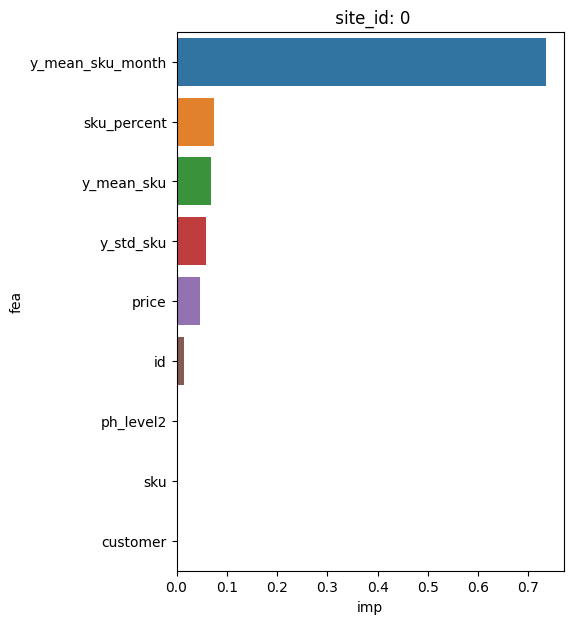

7 0


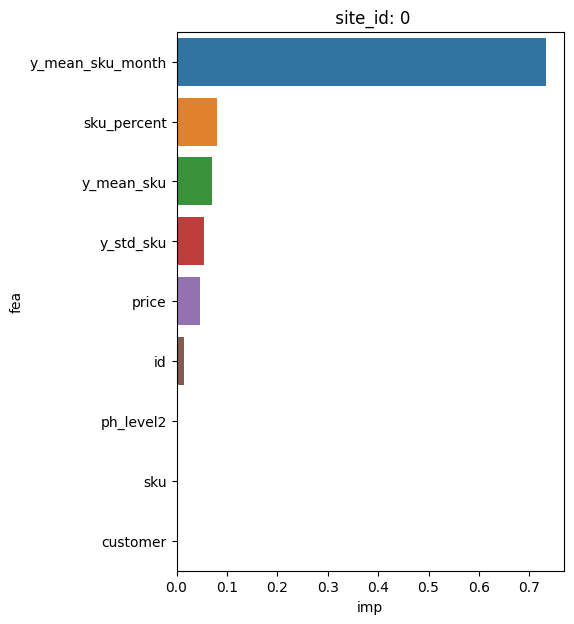

6 0


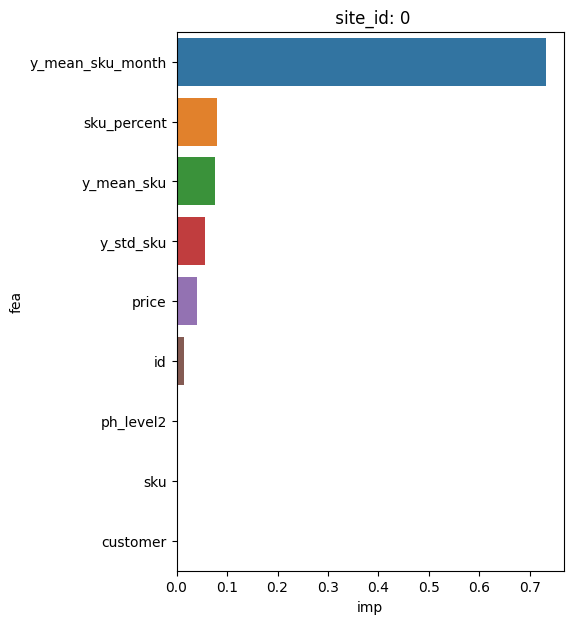

In [76]:
models = {}
clusters = {}
group_var = "customer"
model_name = "Model per customer"
n_clusters = [1]
drop_cols = ["year", "basic_material", "material_description", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
# drop_cols = drop_cols + tsfresh_features

for i in range(len(versions)):
    _x_train = datas[versions[i]]["x_train"].copy()
    _y_train = datas[versions[i]]["y_train"].copy()
 
   
    if (group_var != "ALL"):
        groups = datas[versions[i]]["x_train"][group_var].unique()
    else:
        groups = ["ALL"]
        
    _model = {}
    if(groups[0] != "ALL"):
        for this_group in groups:
            print(versions[i], this_group)
            __x_train = _x_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)
            __y_train = _y_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)

            model = RandomForestRegressor(
                n_estimators=1000,
                criterion="mse",
                max_features="sqrt",
                random_state=0,
                max_samples=0.9,
                n_jobs=-1,  
                verbose=0,
            ) 
            if len(drop_cols) == 0:
                model.fit(__x_train, __y_train)
            else:
                model.fit(__x_train.drop(columns=drop_cols, errors="ignore"), __y_train)

            _model.update({this_group: model})
    else:
        _model = RandomForestRegressor(
            n_estimators=1000,
            criterion="mse",
            max_features="sqrt",
            random_state=0,
            max_samples=0.9,
            n_jobs=-1,  
            verbose=0,
        ) 
        if len(drop_cols) == 0:
            _model.fit(_x_train, _y_train)
        else:
            _model.fit(_x_train.drop(columns=drop_cols, errors="ignore"), _y_train)

        clust_model = None
        labels = None
        _model.update({"ALL": model})
    
    x_train = _x_train.drop(columns=drop_cols, errors="ignore") 
    for sn in _model.keys():
        fea_imp = pd.DataFrame({"fea": x_train.columns.to_list(), "imp": _model[sn].feature_importances_})
        fea_imp.sort_values(by="imp", inplace=True, ascending=False)
        fea_imp = fea_imp.head(20)
        plt.figure(figsize=(5, 7))
        sns.barplot(data=fea_imp, x="imp", y="fea")
        plt.title(" site_id: {}".format( sn))
        plt.show()
    models.update({versions[i]: _model})
    
    


In [77]:


predict_df = []
for i in range(len(versions)):
    
    x_train = datas[versions[i]]["x_train"]
    x_test = datas[versions[i]]["x_test"]
    x_predict = datas[versions[i]]["x_predict"]
    yhat_train = np.zeros(x_train.shape[0])
    yhat_test = np.zeros(x_test.shape[0])
    yhat_predict = np.zeros(x_predict.shape[0])
    
    _model = models[versions[i]]
    if (group_var != "ALL"):      
        for sn in _model.keys():
            model = _model[sn]
            yhat_train = model.predict(x_train.loc[x_train[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_test = model.predict(x_test.loc[x_test[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_predict = model.predict(x_predict.loc[x_predict[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            if group_var == 'sku':
                sn2 = sn
            else:
                sn2 = encoders[versions[i],group_var].inverse_transform([sn])[0]
            a = pd.concat([
                datas[versions[i]]["train"].loc[datas[versions[i]]["train"][group_var]==sn2], 
                datas[versions[i]]["test"].loc[datas[versions[i]]["test"][group_var]==sn2],
                datas[versions[i]]["predict"].loc[datas[versions[i]]["predict"][group_var]==sn2]
            ]).reset_index(drop=True)
            a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
            a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
            a["model"] = model_name
            a["version"] = versions[i]
            predict_df.append(a)
    else:
        model = _model['ALL']
        yhat_train = model.predict(x_train.drop(columns=drop_cols,errors= 'ignore'))
        yhat_test = model.predict(x_test.drop(columns=drop_cols,errors= 'ignore'))
        yhat_predict = model.predict(x_predict.drop(columns=drop_cols,errors= 'ignore'))

        sn2 = encoders[group_var].inverse_transform([sn])[0]
        a = pd.concat([
            datas[versions[i]]["train"], 
            datas[versions[i]]["test"],
            datas[versions[i]]["predict"]
        ]).reset_index(drop=True)
        a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
        a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
        a["model"] = model_name
        a["version"] = versions[i]
        predict_df.append(a)
predict_df = pd.concat(predict_df).reset_index(drop=True)  
        

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-07-01T00:00:00.000000000']
['2022-08-01T00:00:00.000000000']
['2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.

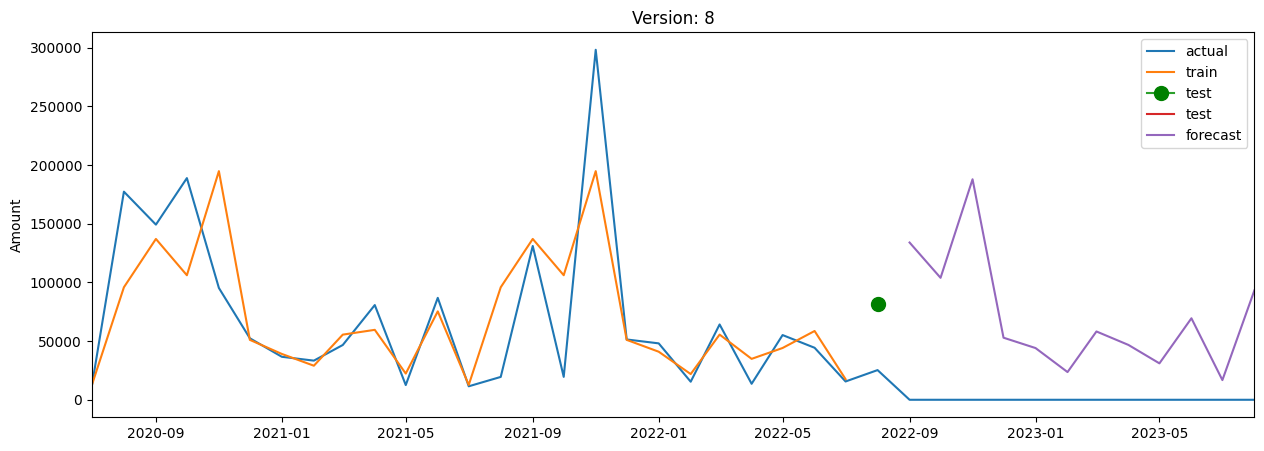

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000']
['2022-07-01T00:00:00.000000000']
['2022-08-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-01T00:00:00.000000000' '2022-11-01T00:00:00.000000000'
 '2022-12-01T00:00:00.000000000' '2023-01-01T00:00:00.0

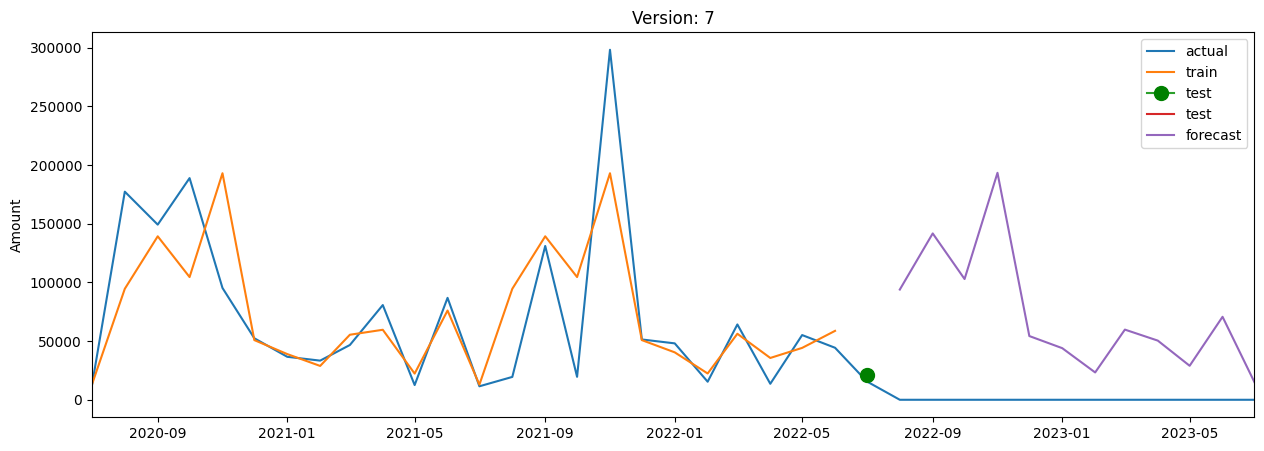

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000']
['2022-06-01T00:00:00.000000000']
['2022-07-01T00:00:00.000000000' '2022-08-01T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.

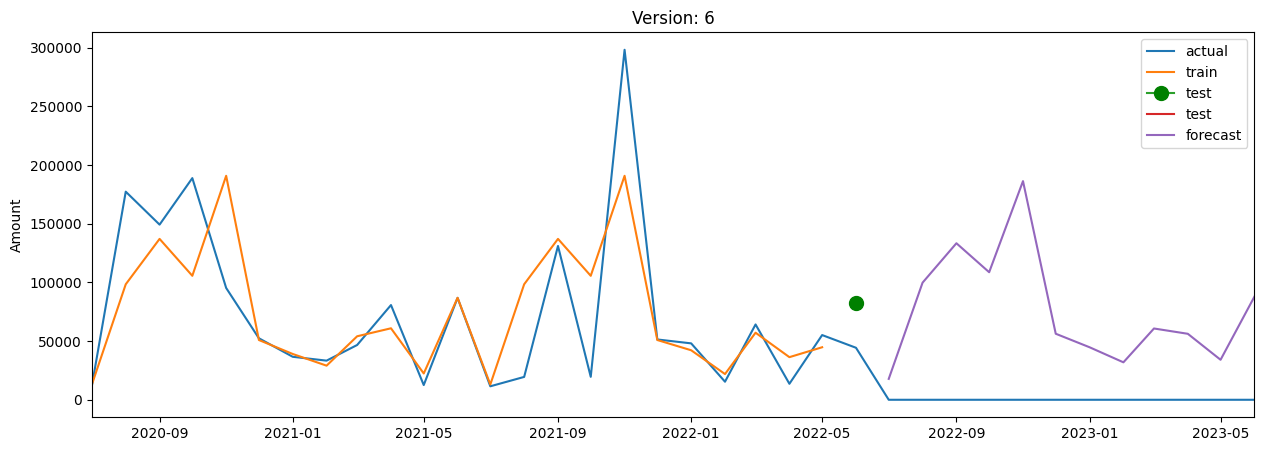

In [78]:
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
    ts = a.set_index("ts").resample("MS").sum().reset_index()
    train = ts.loc[ts.ts < dates["test"][0]]
    test = ts.loc[(ts.ts < dates["forecast"][0]) & (ts.ts >= dates["test"][0])]
    predict = ts.loc[ts.ts >= dates["forecast"][0]]
    
    print(train.ts.unique())
    print(test.ts.unique())
    print(predict.ts.unique())
    
    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")
    plt.plot(train.ts, train.yhat, label="train")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")
    
    plt.plot(test.ts, test.yhat, label="test")
    plt.plot(predict.ts, predict.yhat, label="forecast")
    plt.xlim([ts.ts.min(), ts.ts.max()])
    plt.ylabel("Amount")
    plt.title("Version: {}".format(versions[i]))
    plt.legend()
    plt.show()

In [66]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion'] = events['promotion'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')

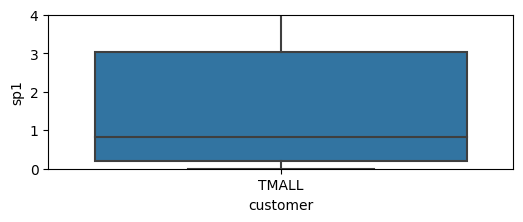

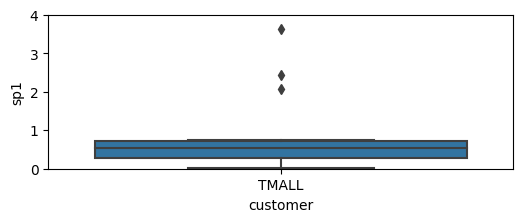

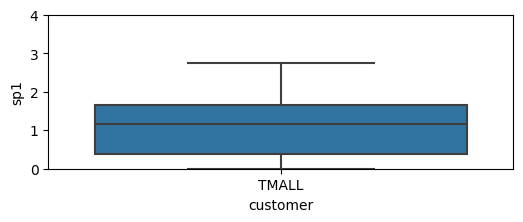

In [94]:
results = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        if(ts.shape[0] == 0):
            continue
        test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": all_dates[versions[i]]["test"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "customer", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]

results.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results.groupby("customer").mean()
results.groupby("customer").median()

for i in range(len(versions)): 
    this_results = results[results['version'] == versions[i]]
    plt.figure(figsize=(6,2))
    plt.ylim(0,4)
    sns.boxplot(data=this_results, y="sp1", x="customer")
    plt.show()

    

In [95]:
results

id           sku customer  version test_start   test_end  total_actual  total_forecast     rmse      mae     smape           mape     maape        sp1               model
0    0  815517026005    TMALL        8 2022-08-01 2022-08-01         108.0           855.0    747.0    747.0  1.551402   6.916667e+00  1.427213   0.126316  Model per customer
1    1  815517026012    TMALL        8 2022-08-01 2022-08-01           0.0           854.0    854.0    854.0  2.000000  1.797693e+308  1.570796   0.000000  Model per customer
2    2  815517026029    TMALL        8 2022-08-01 2022-08-01         289.0           327.0     38.0     38.0  0.123377   1.314879e-01  0.130738   0.883792  Model per customer
3    3  815517026036    TMALL        8 2022-08-01 2022-08-01        2288.0         36001.0  33713.0  33713.0  1.760976   1.473470e+01  1.503033   0.063554  Model per customer
4    4  815517026043    TMALL        8 2022-08-01 2022-08-01         189.0           120.0     69.0     69.0  0.446602   3.650794e-01  0.350045   1.575000  Model per customer
5    5  815517026050    TMALL        8 2022-08-01 2022-08-01          16.0            30.0     14.0     14.0  0.608696   8.750000e-01  0.718830   0.533333  Model per customer
6    6  815517026067    TMALL        8 2022-08-01 2022-08-01        1509.0         12623.0  11114.0  11114.0  1.572884   7.365142e+00  1.435847   0.119544  Model per customer
7    7  815517026081    TMALL        8 2022-08-01 2022-08-01        4013.0         21830.0  17817.0  17817.0  1.378865   4.439821e+00  1.349259   0.183830  Model per customer
8    8  815517026265    TMALL        8 2022-08-01 2022-08-01        1217.0          2115.0    898.0    898.0  0.539016   7.378800e-01  0.635699   0.575414  Model per customer
9    9  815517026272    TMALL        8 2022-08-01 2022-08-01        3112.0          4183.0   1071.0   1071.0  0.293626   3.441517e-01  0.331455   0.743964  Model per customer
10  10  815517026999    TMALL        8 2022-08-01 2022-08-01        6125.0          1622.0   4503.0   4503.0  1.162515   7.351837e-01  0.633951   3.776202  Model per customer
11  11  815517027163    TMALL        8 2022-08-01 2022-08-01        2161.0           461.0   1700.0   1700.0  1.296720   7.866728e-01  0.666562   4.687636  Model per customer
12  12  815517027170    TMALL        8 2022-08-01 2022-08-01         839.0           317.0    522.0    522.0  0.903114   6.221692e-01  0.556561   2.646688  Model per customer
13  13  815517027606    TMALL        8 2022-08-01 2022-08-01          44.0            14.0     30.0     30.0  1.034483   6.818182e-01  0.598419   3.142857  Model per customer
14  14  815517027613    TMALL        8 2022-08-01 2022-08-01        1157.0            50.0   1107.0   1107.0  1.834300   9.567848e-01  0.763317  23.140000  Model per customer
15  32  815517025992    TMALL        8 2022-08-01 2022-08-01         205.0            80.0    125.0    125.0  0.877193   6.097561e-01  0.547562   2.562500  Model per customer
16  33  815517027491    TMALL        8 2022-08-01 2022-08-01          11.0            37.0     26.0     26.0  1.083333   2.363636e+00  1.170556   0.297297  Model per customer
17  50  815517028122    TMALL        8 2022-08-01 2022-08-01        2006.0           488.0   1518.0   1518.0  1.217322   7.567298e-01  0.647794   4.110656  Model per customer
18   0  815517026005    TMALL        7 2022-07-01 2022-07-01         175.0           592.0    417.0    417.0  1.087353   2.382857e+00  1.173454   0.295608  Model per customer
19   1  815517026012    TMALL        7 2022-07-01 2022-07-01          13.0           499.0    486.0    486.0  1.898438   3.738462e+01  1.544054   0.026052  Model per customer
20   2  815517026029    TMALL        7 2022-07-01 2022-07-01         175.0           463.0    288.0    288.0  0.902821   1.645714e+00  1.024779   0.377970  Model per customer
21   3  815517026036    TMALL        7 2022-07-01 2022-07-01        1284.0          2460.0   1176.0   1176.0  0.628205   9.158879e-01  0.741524   0.521951

In [38]:
_id=9
i=0
ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)

test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()

metrics = calc_metrics(test.y, test.yhat)
metrics.update({
    "id": _id,
    "version" : versions[i],
    "sku": ts["sku"][0],
    "customer": ts["customer"][0],
    "test_start": all_dates[versions[i]]["test"][0],
    "test_end": all_dates[versions[i]]["test"][-1],
    "total_actual": test.y.sum(),
    "total_forecast": test.yhat.sum(),
})

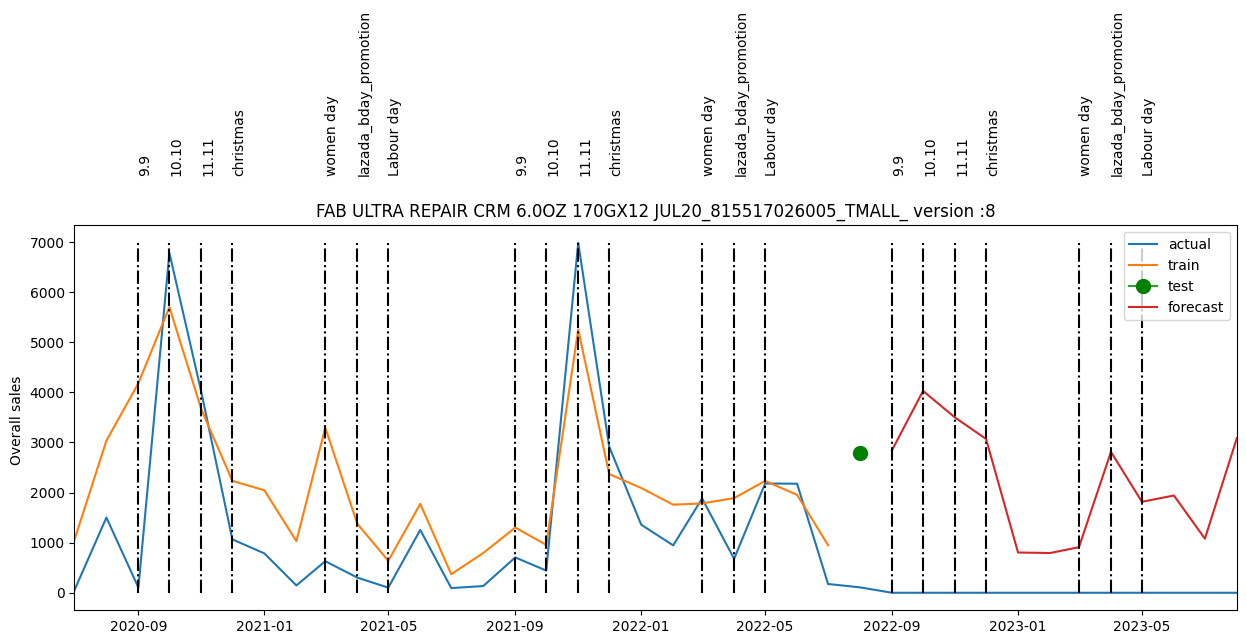

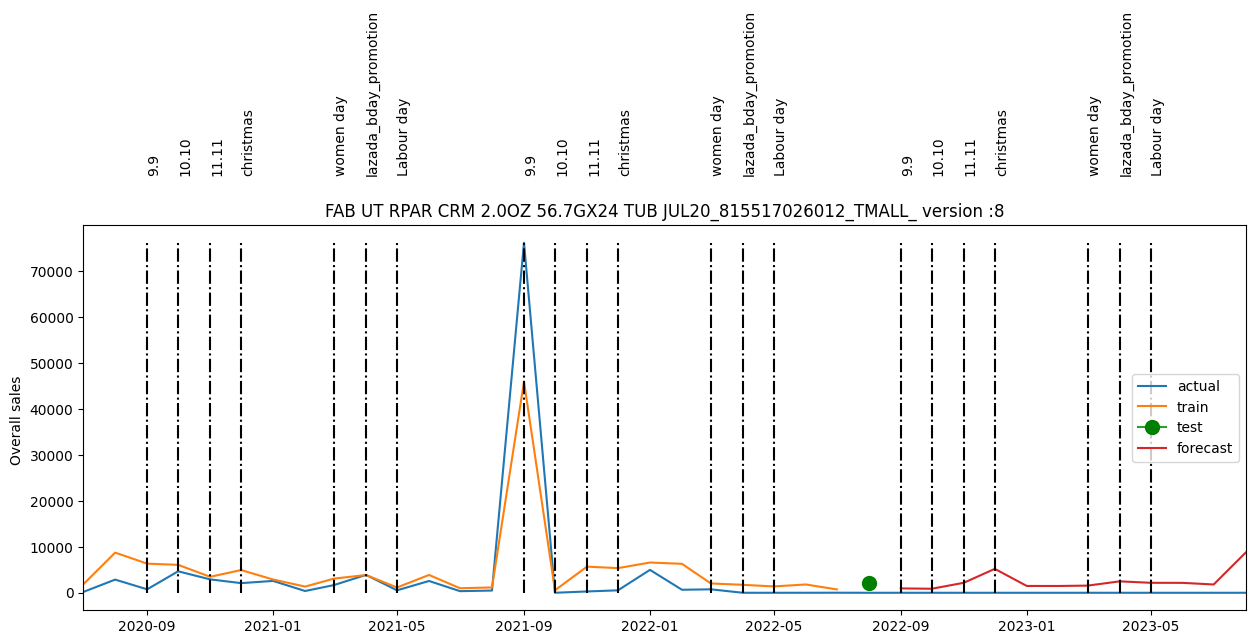

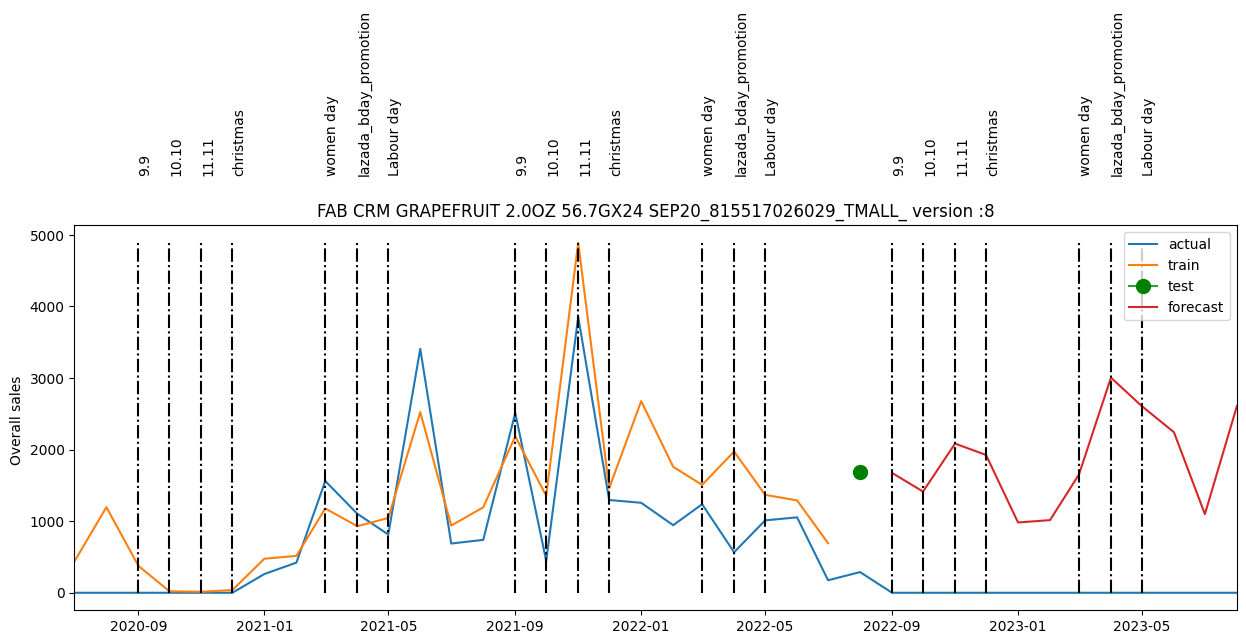

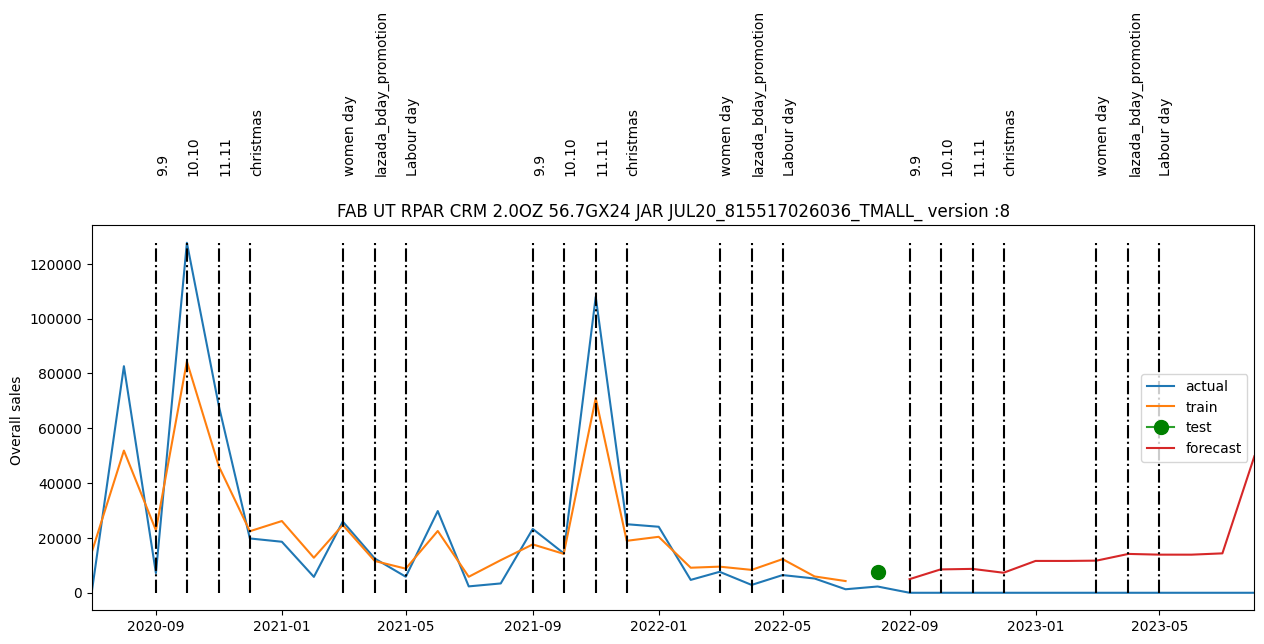

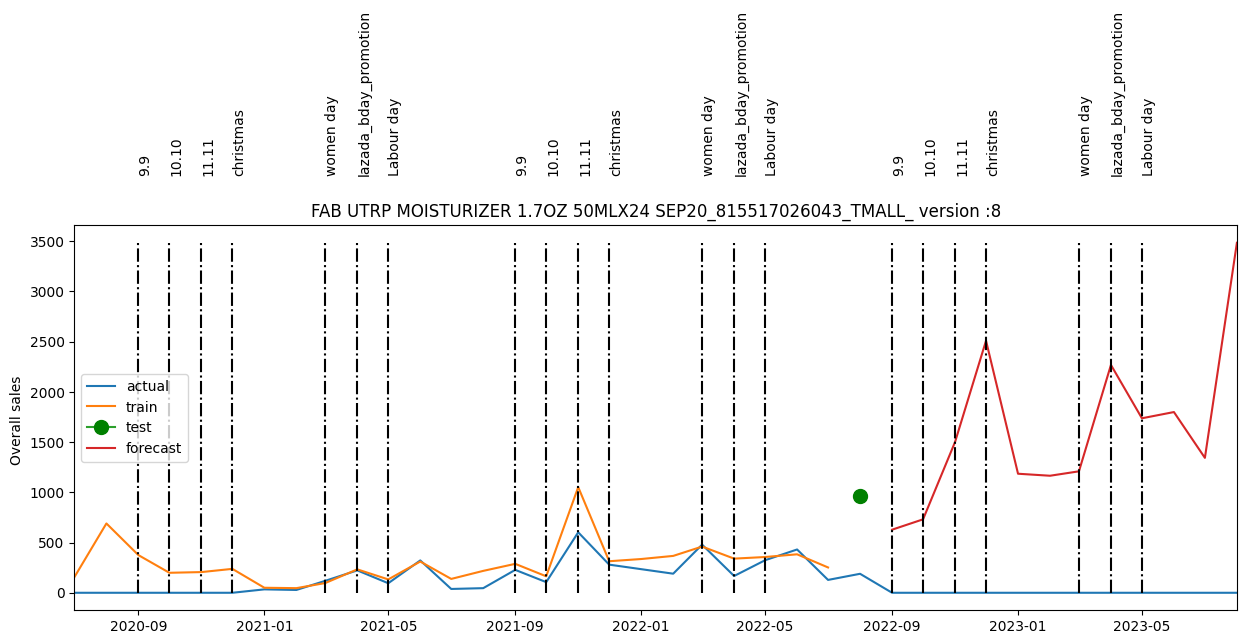

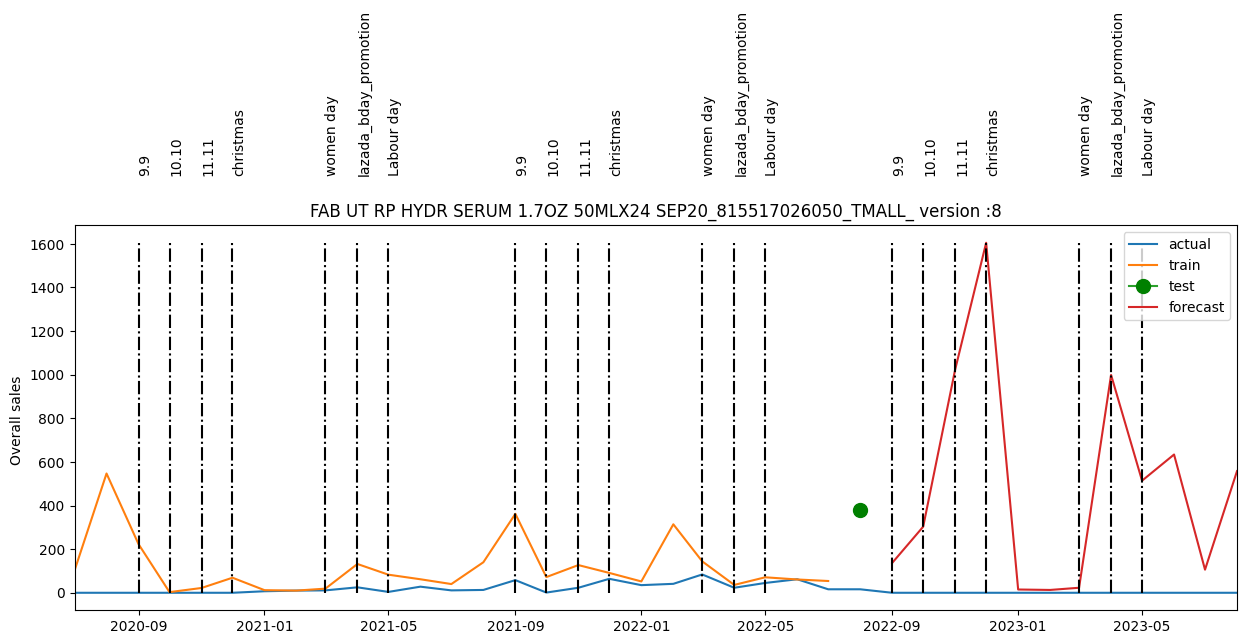

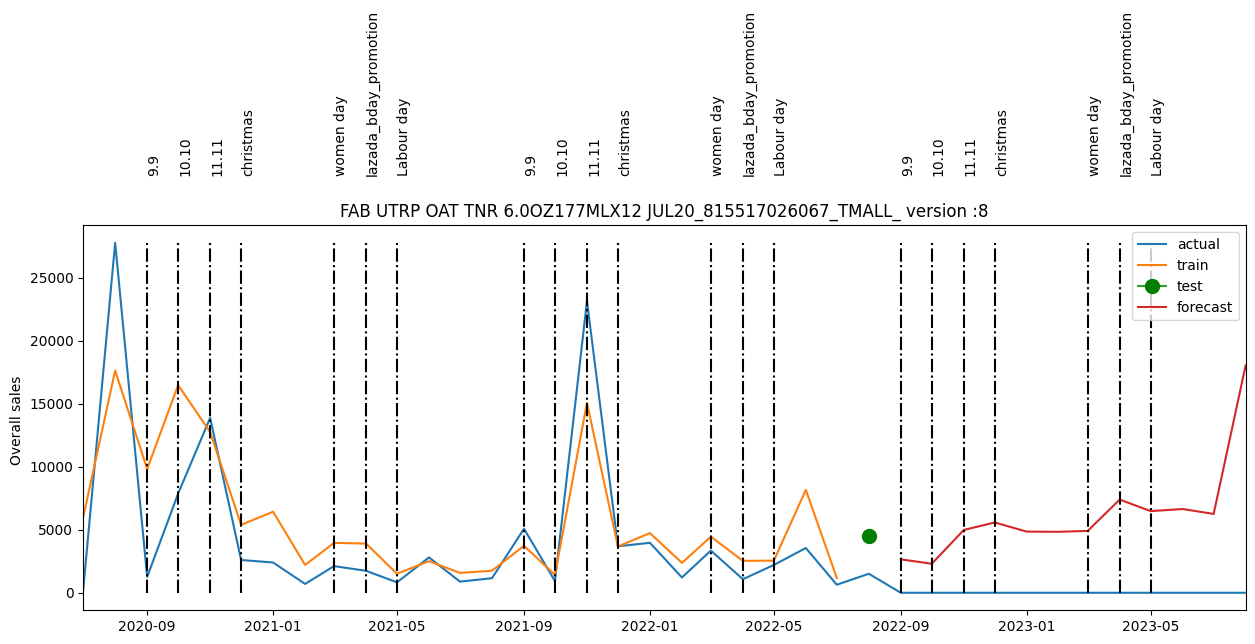

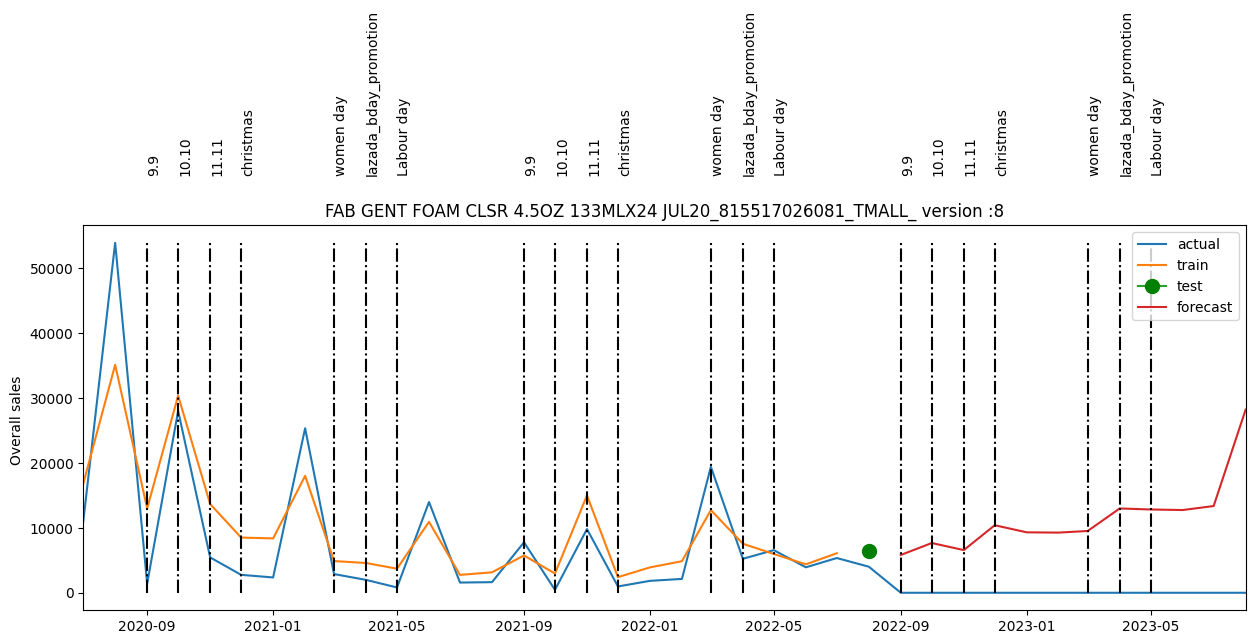

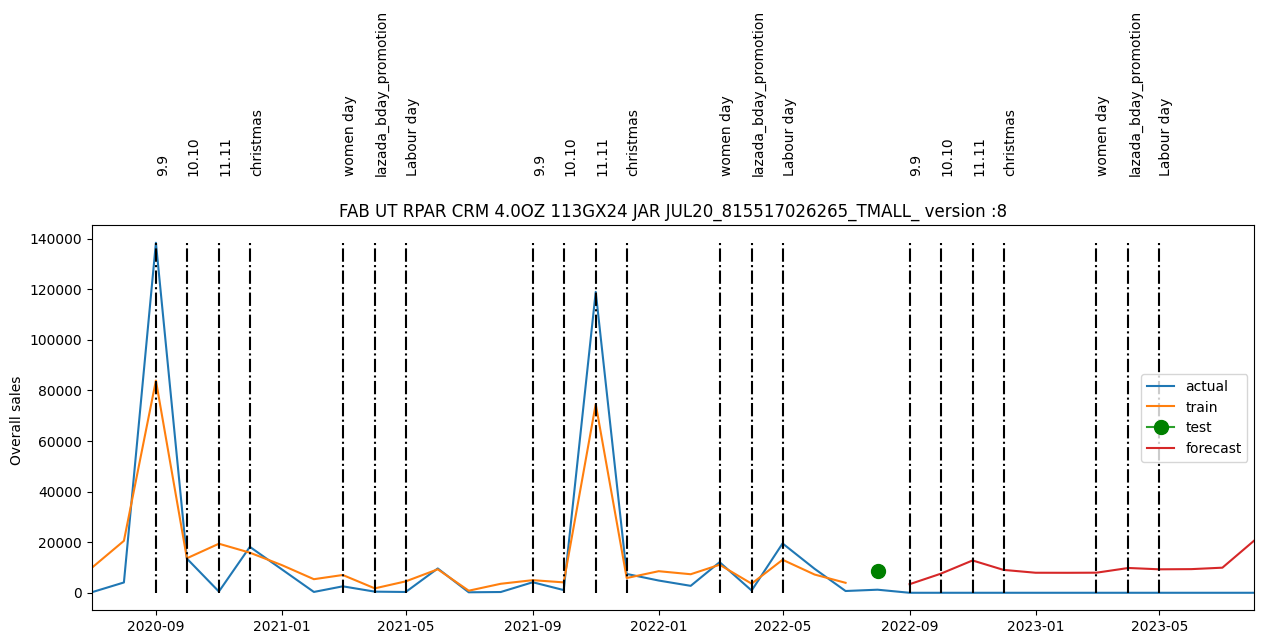

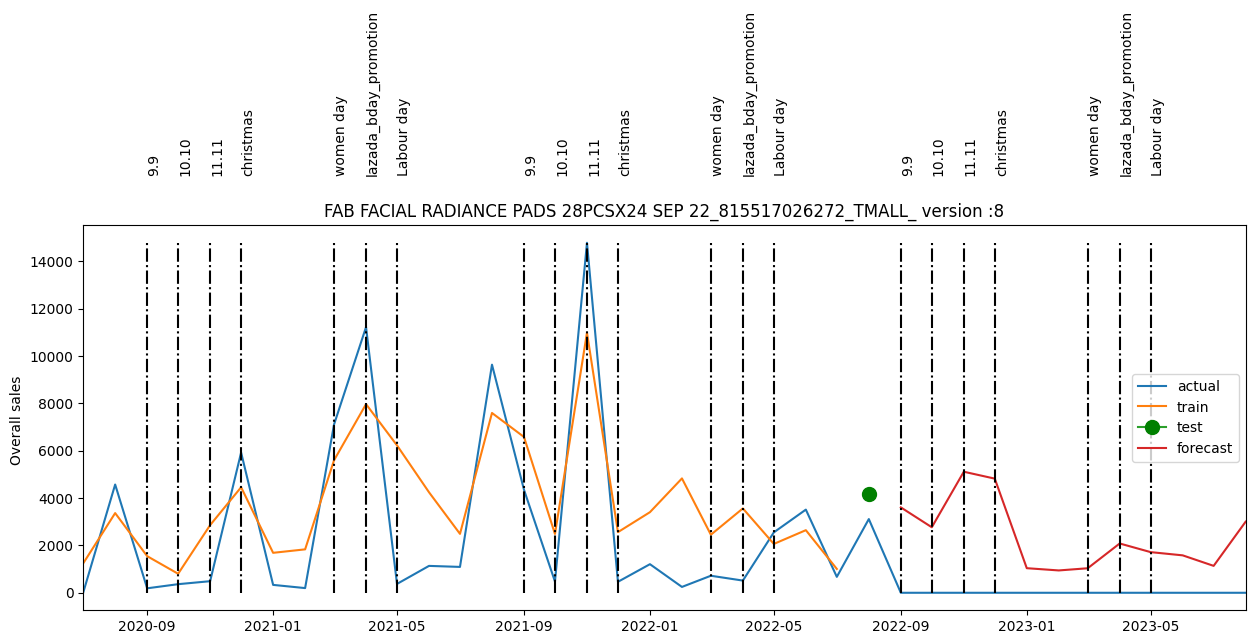

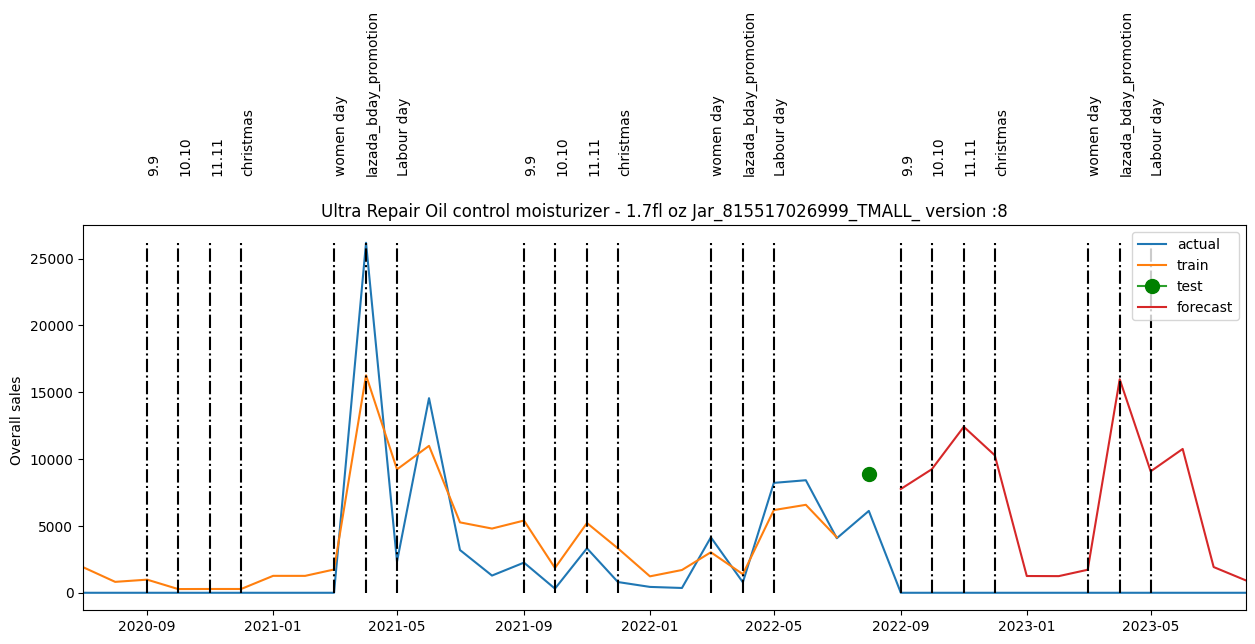

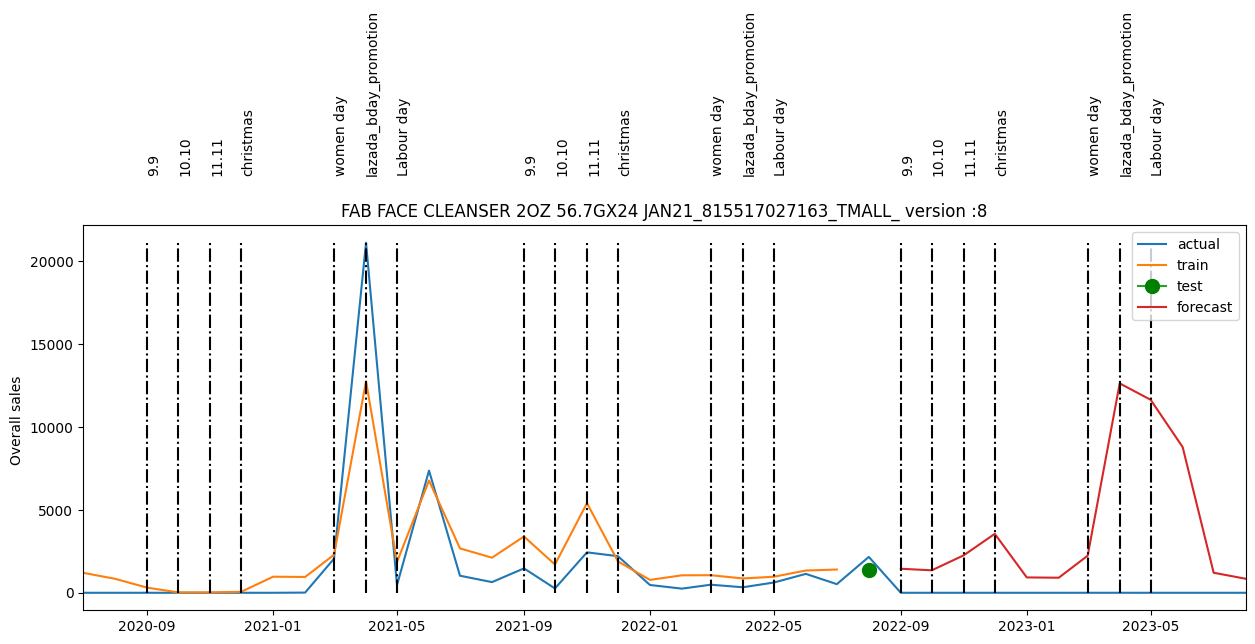

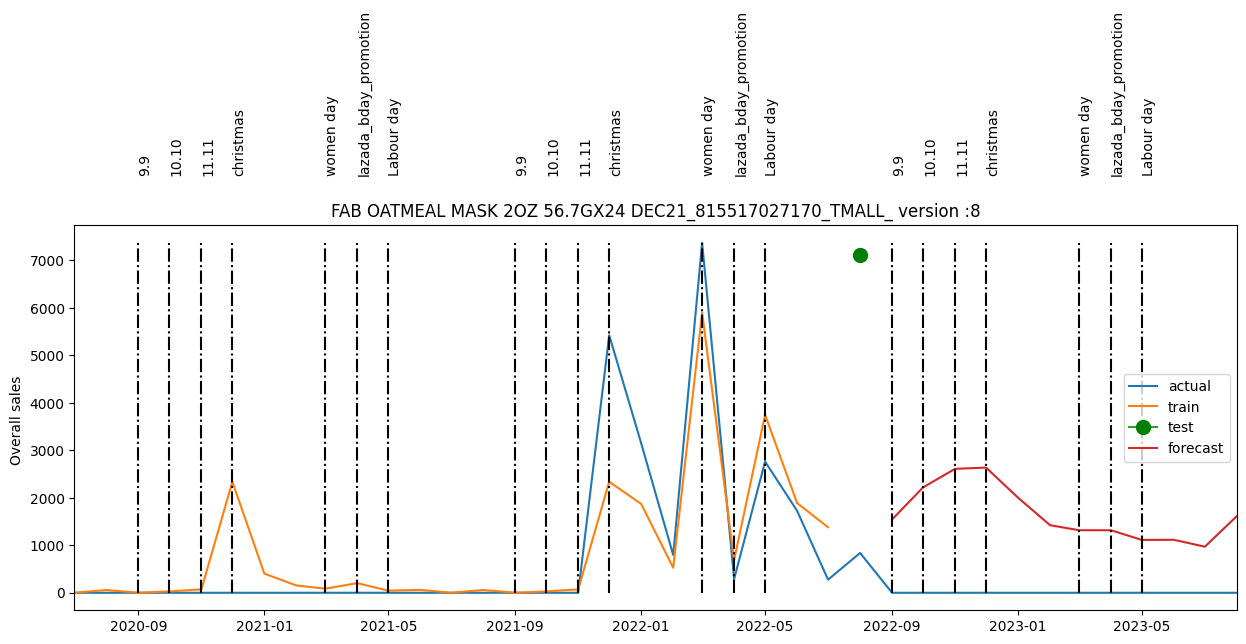

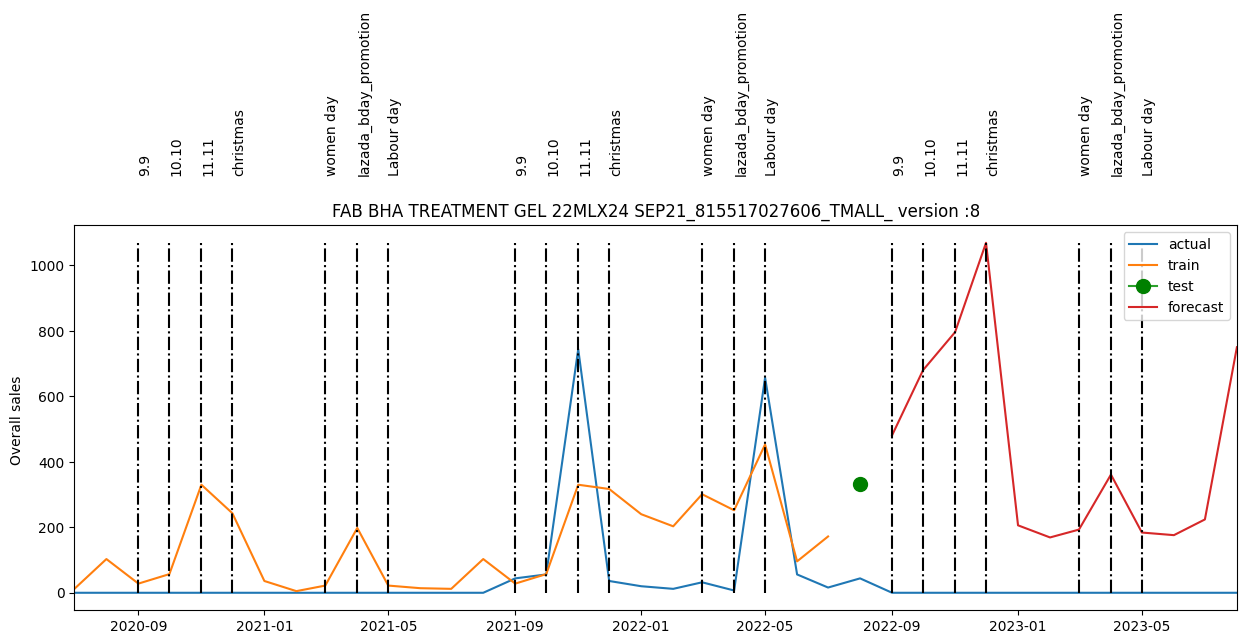

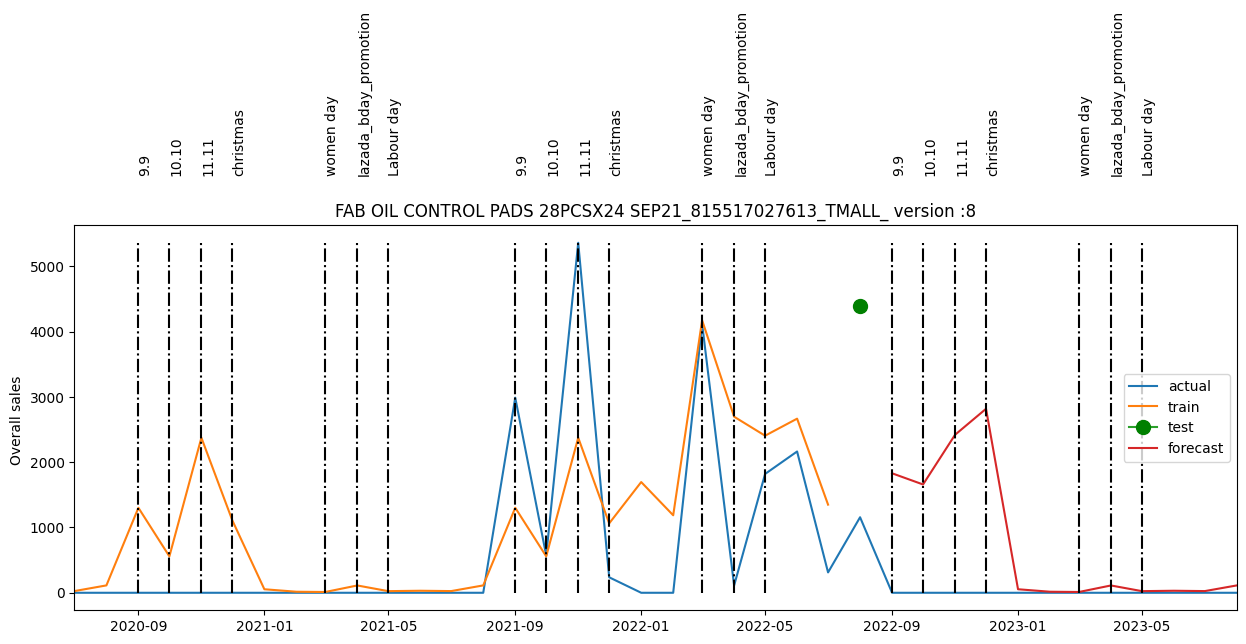

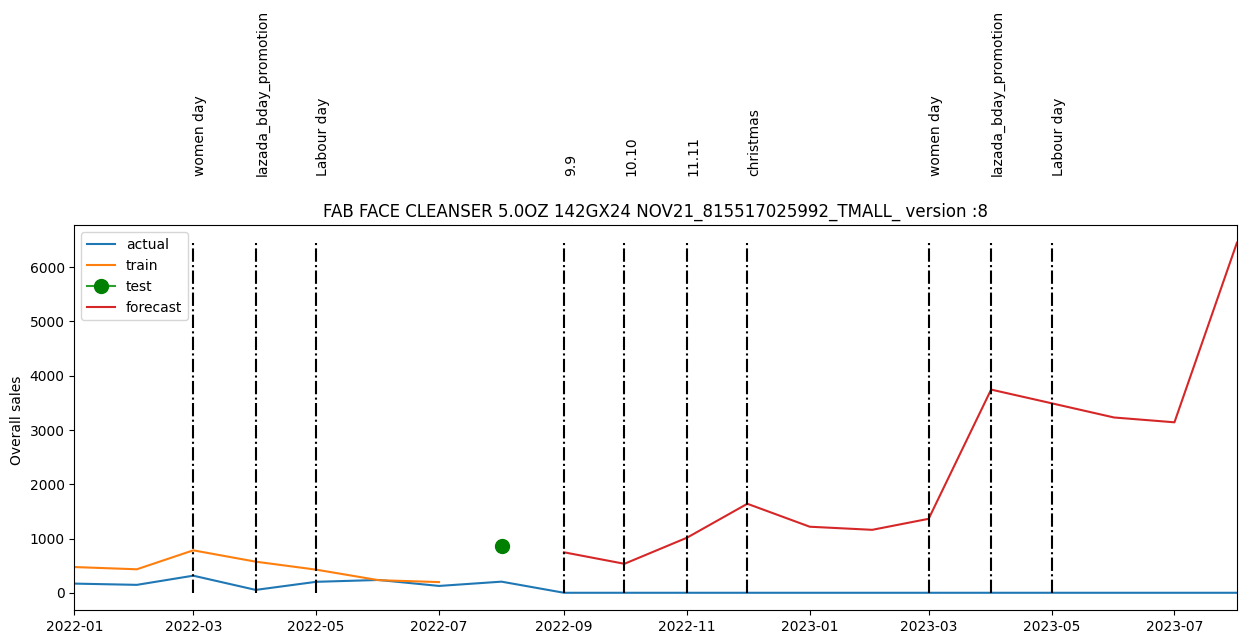

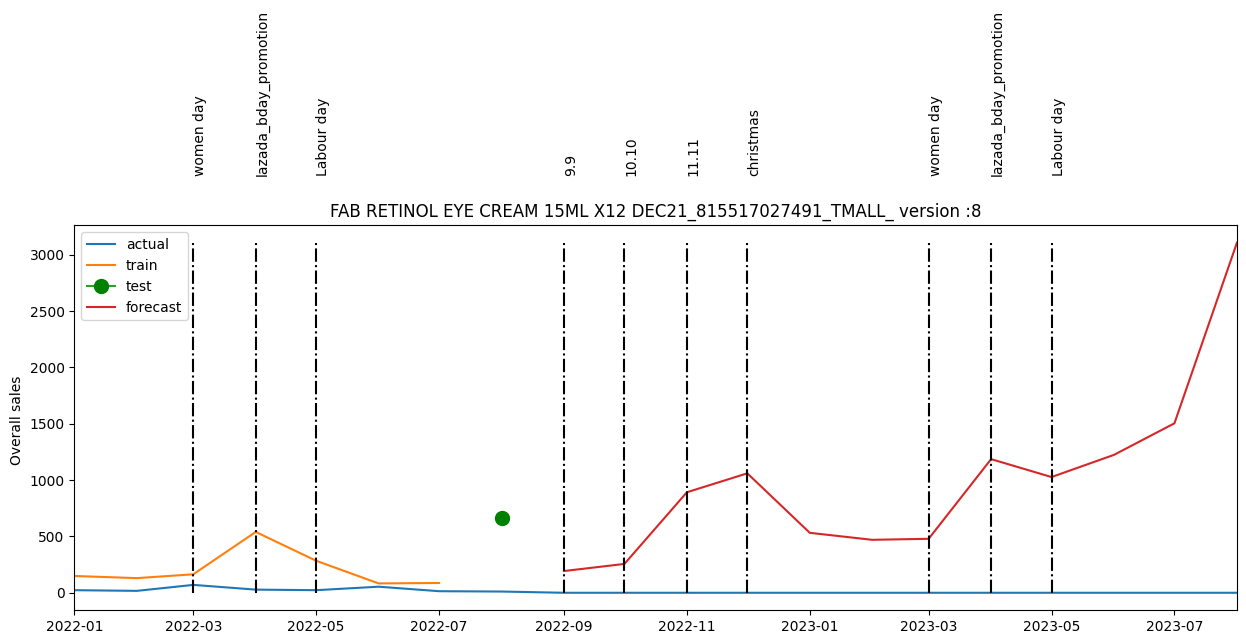

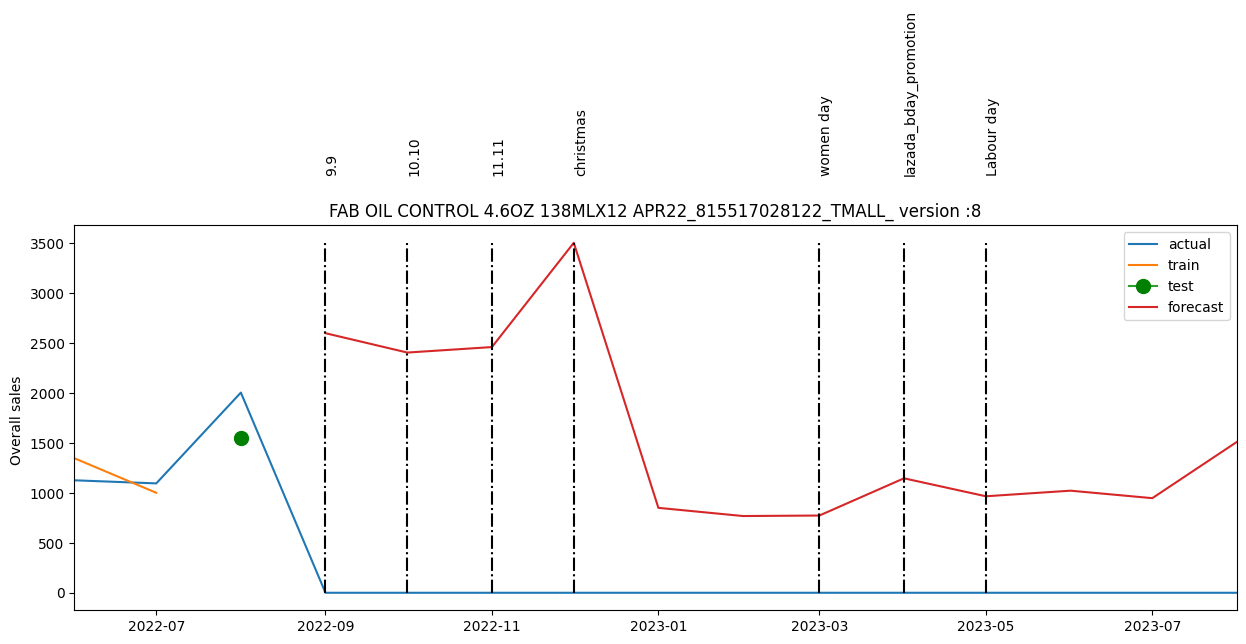

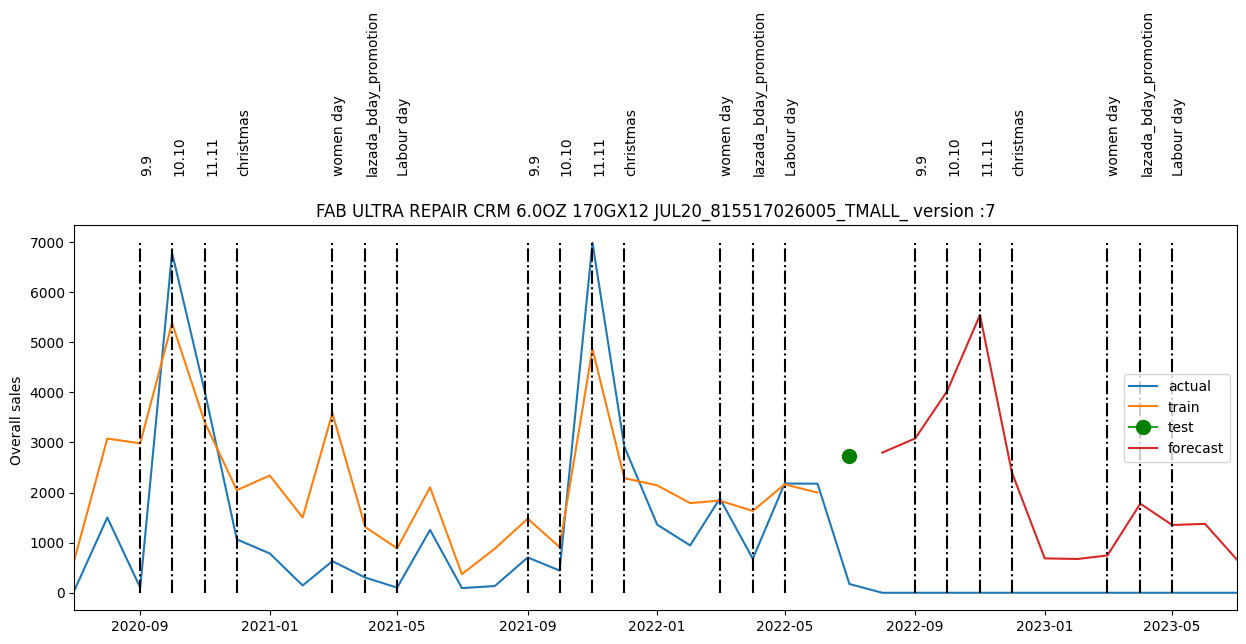

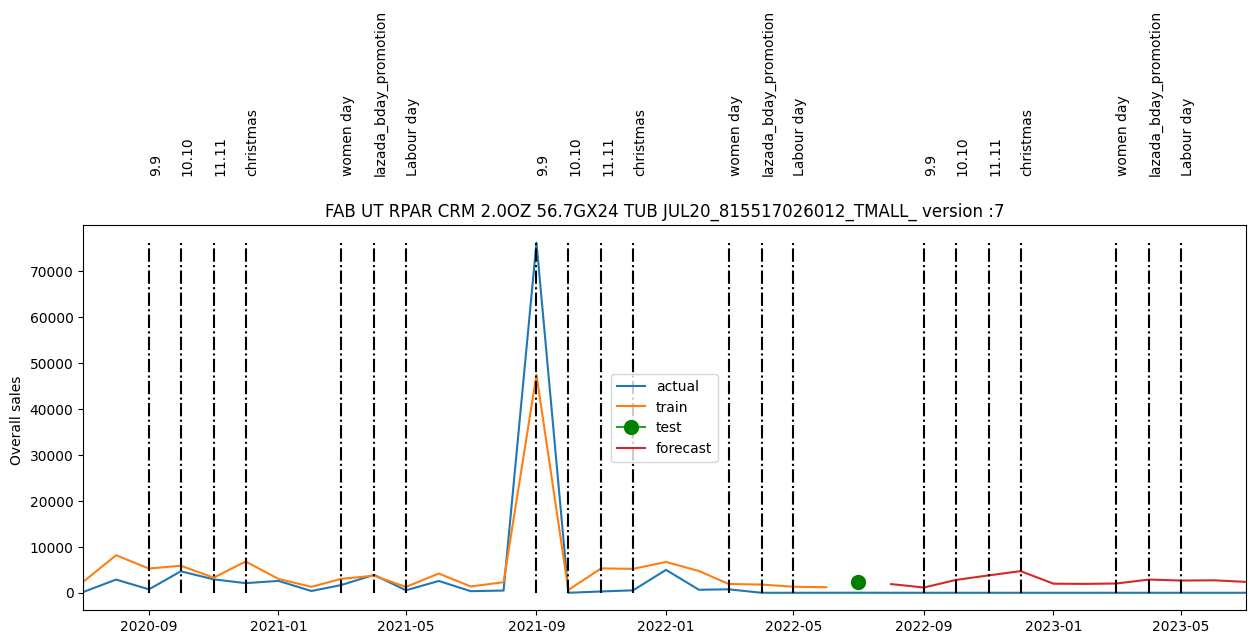

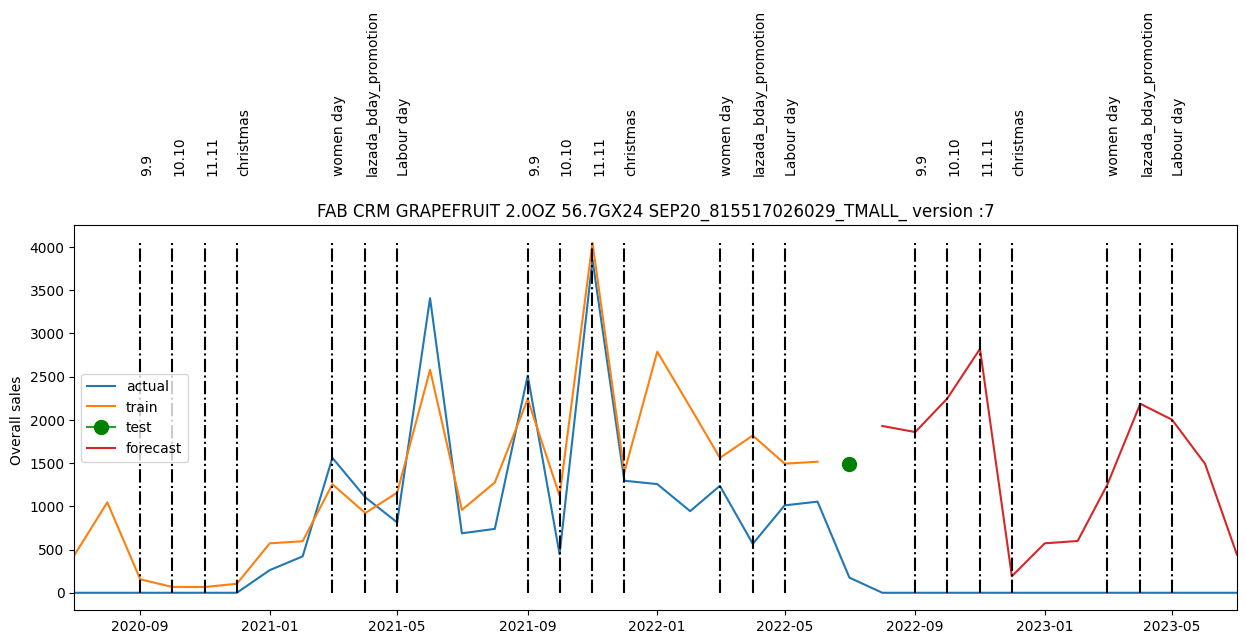

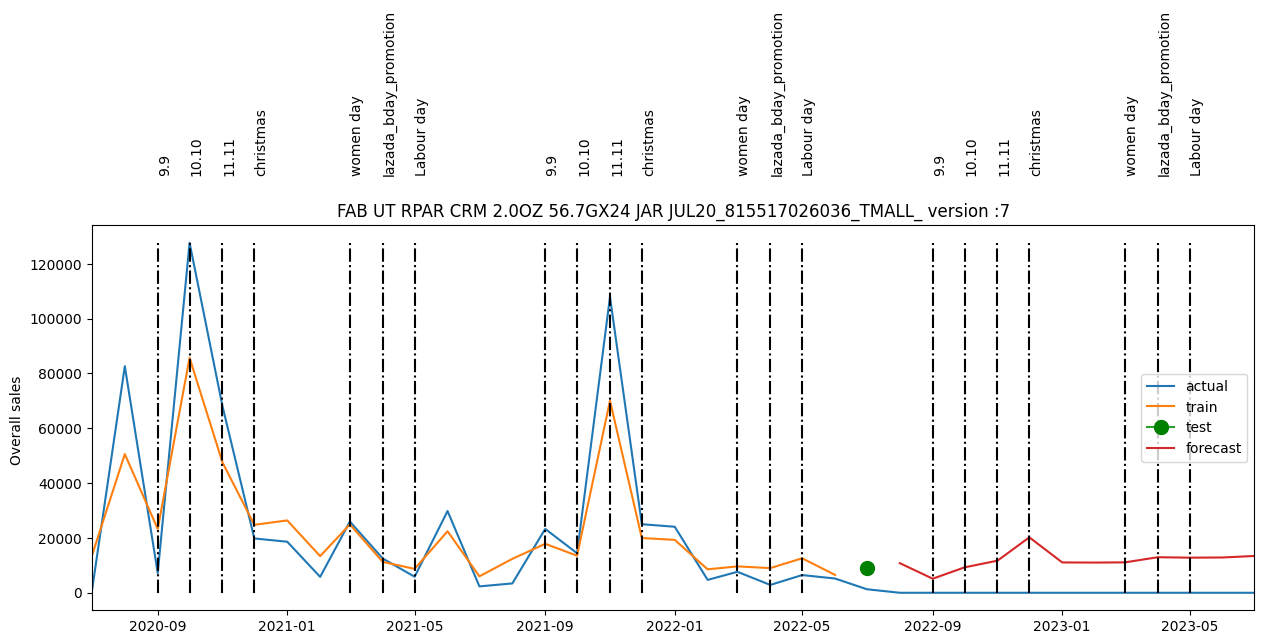

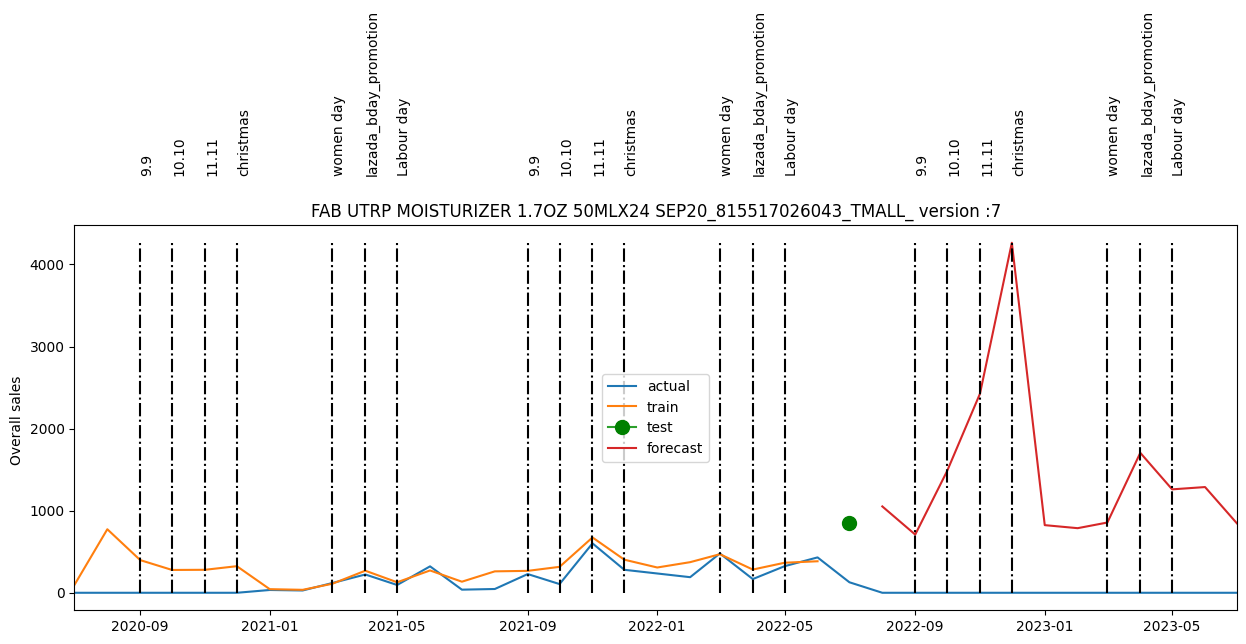

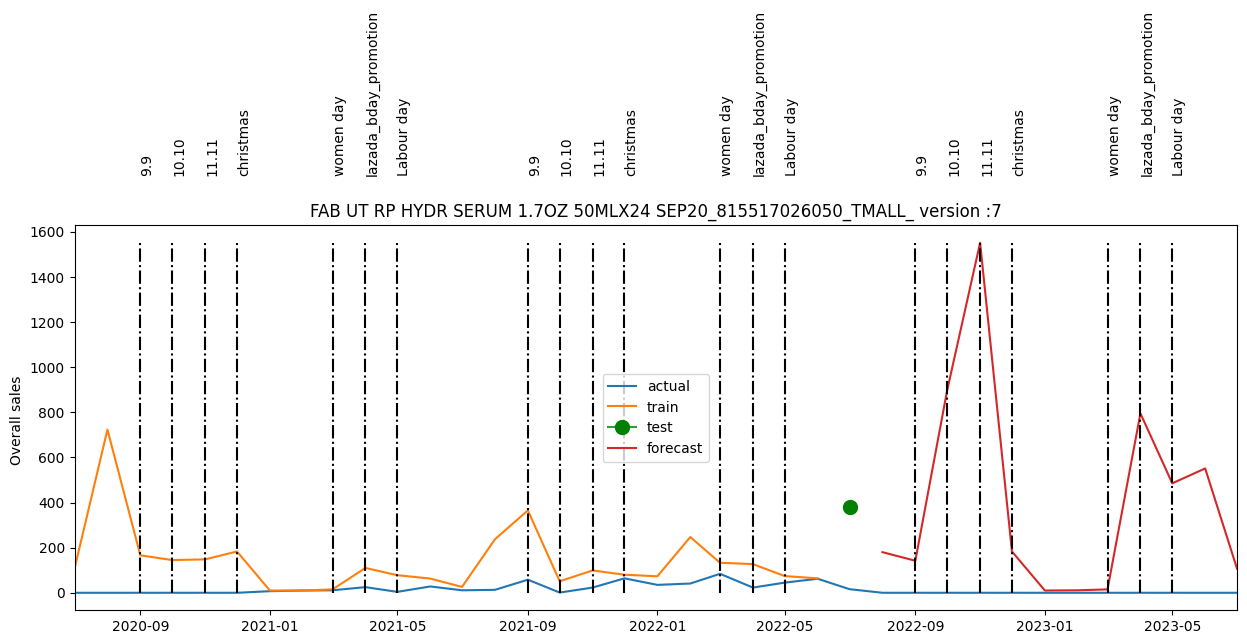

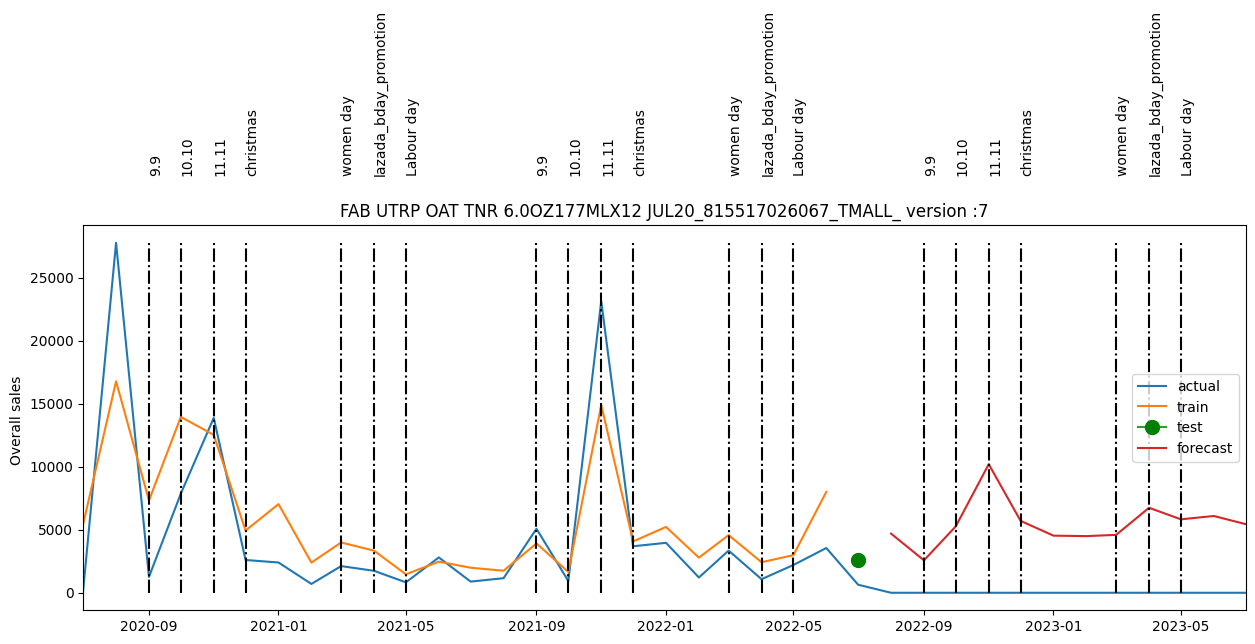

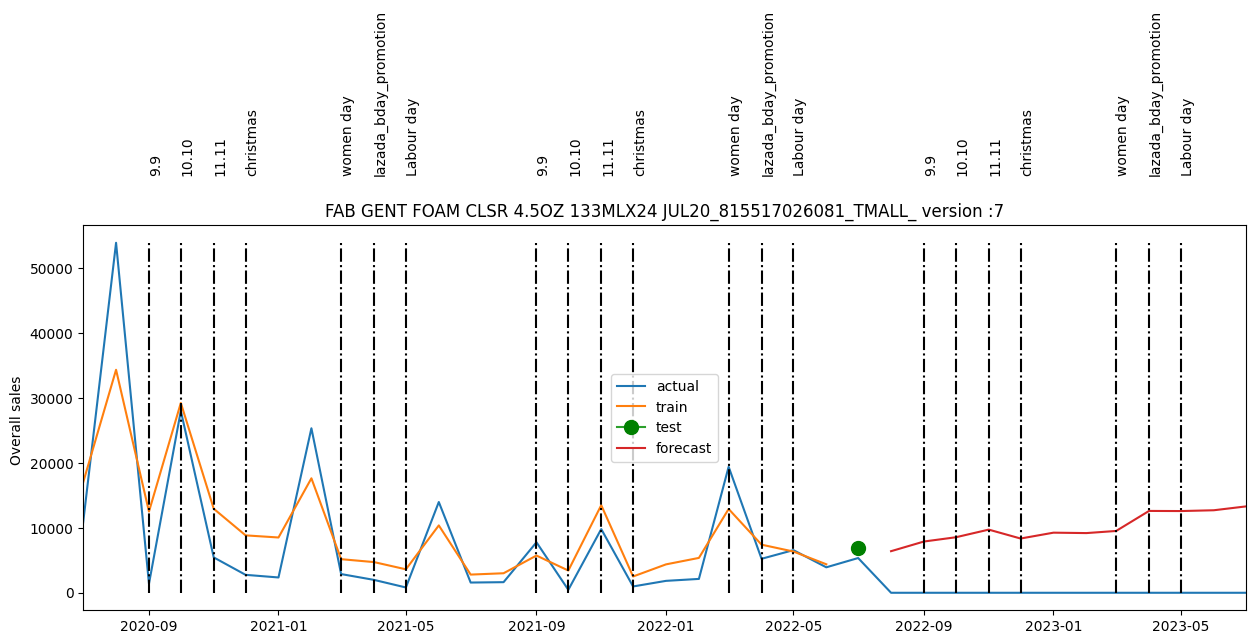

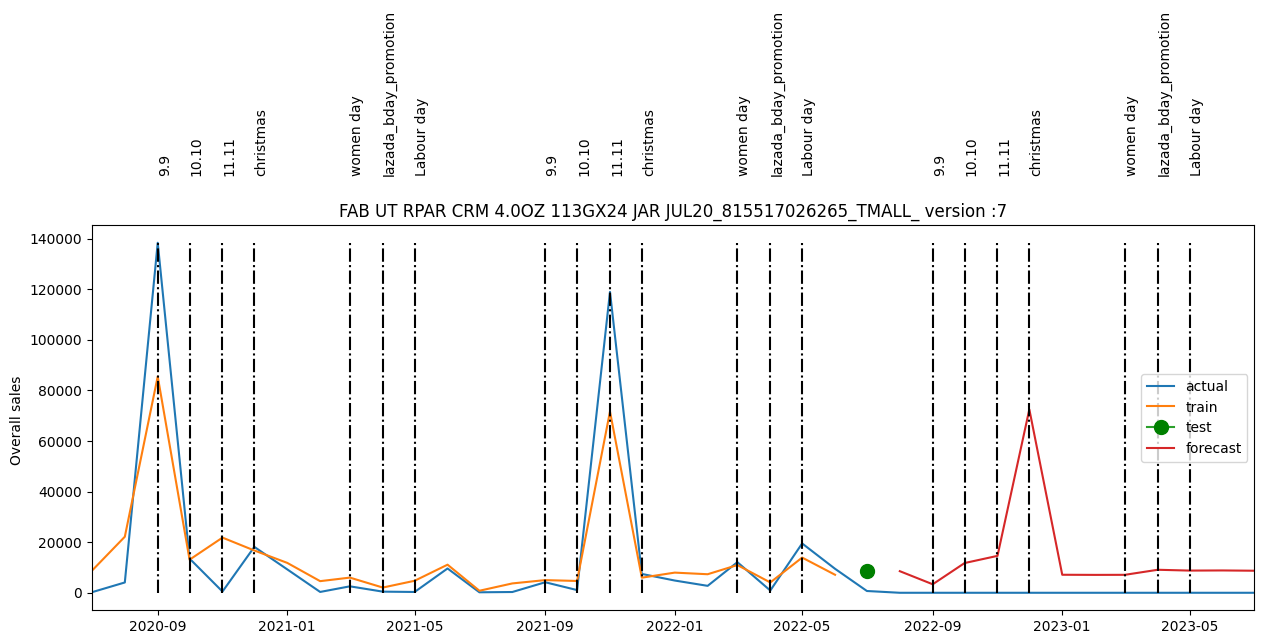

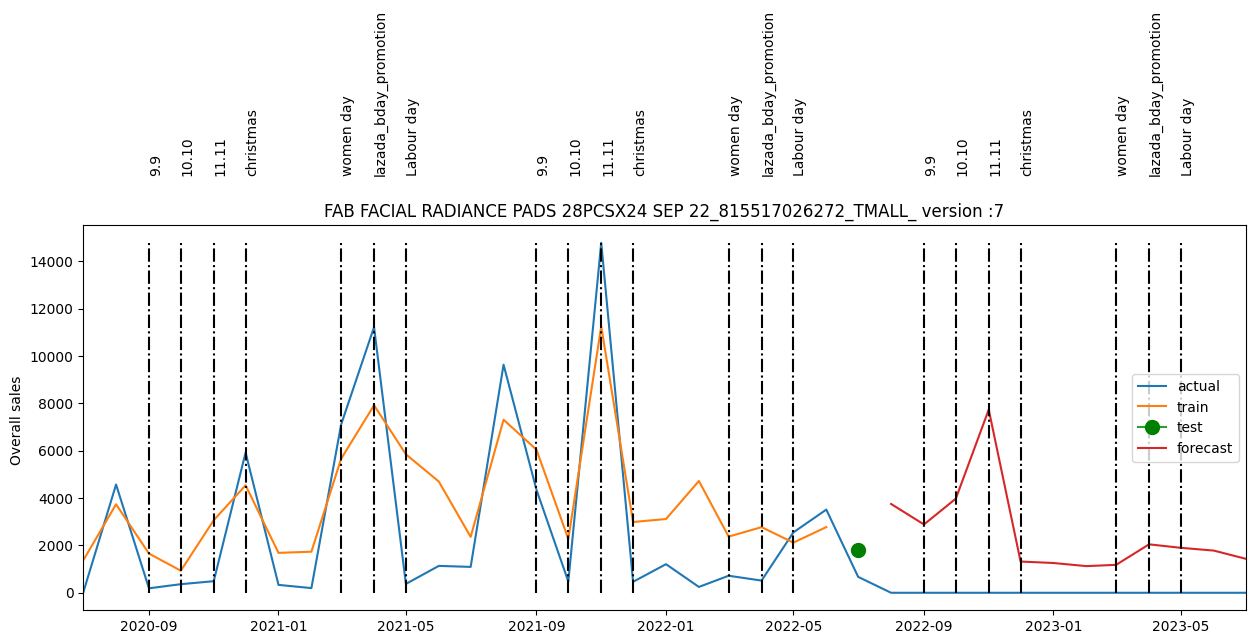

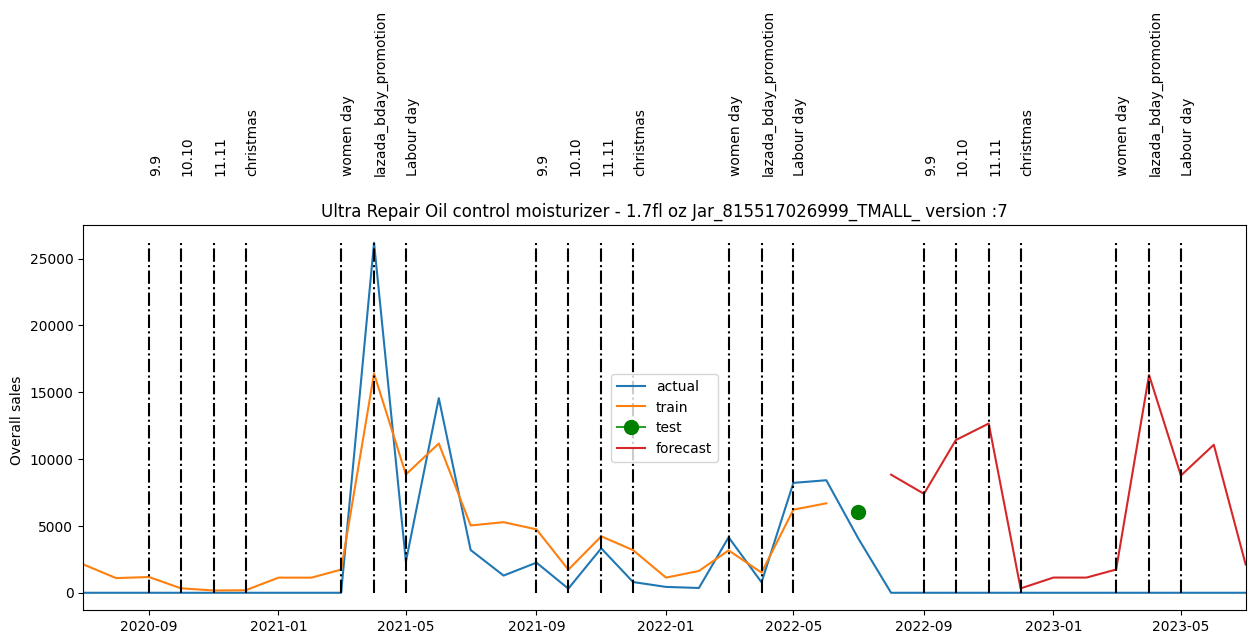

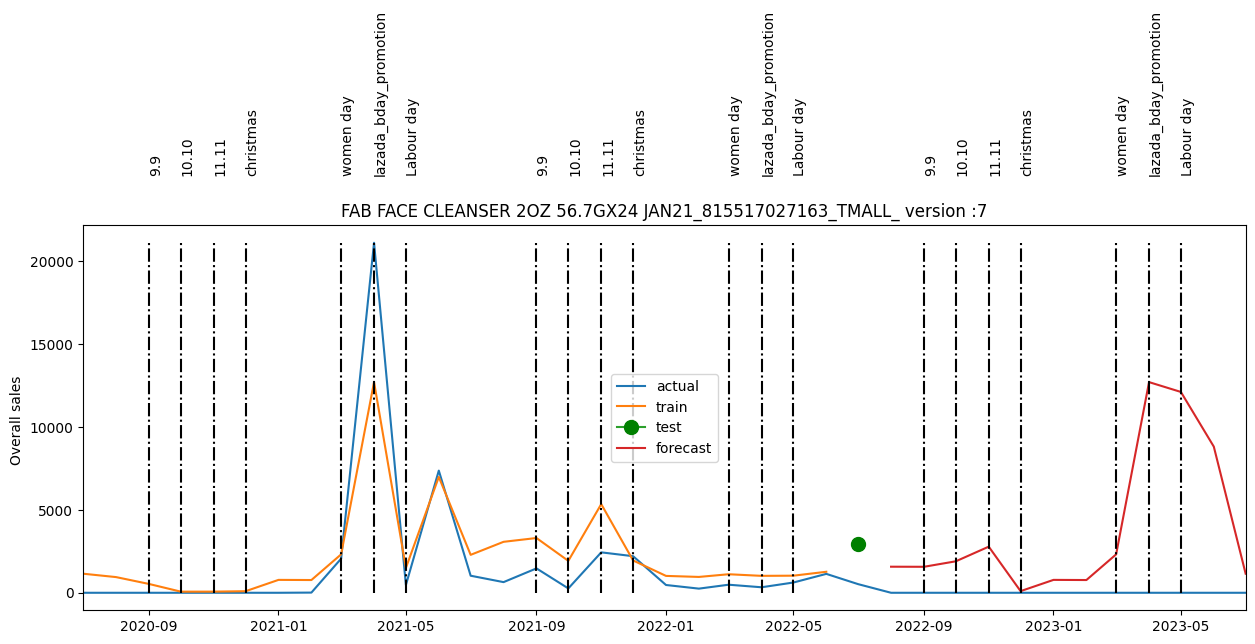

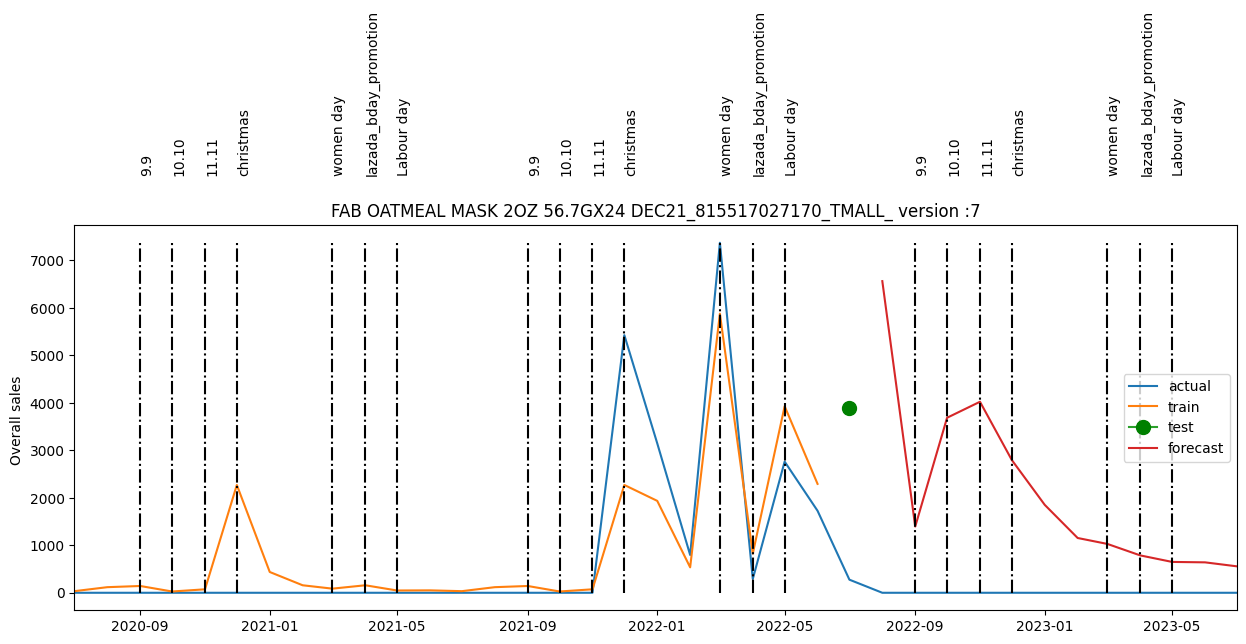

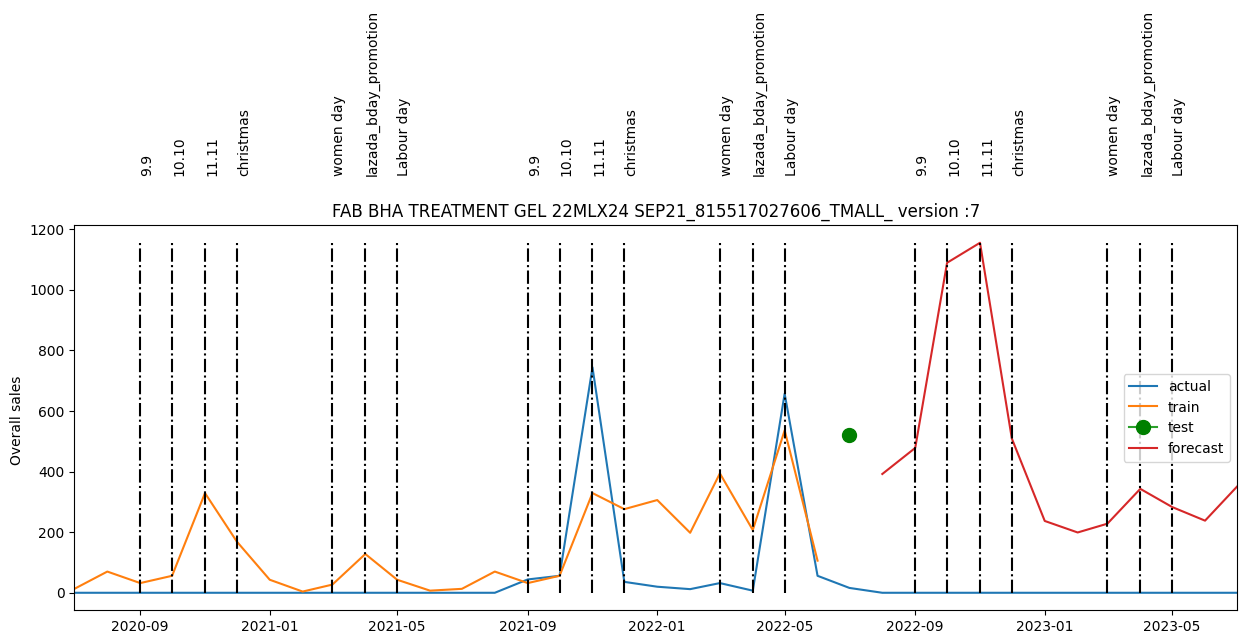

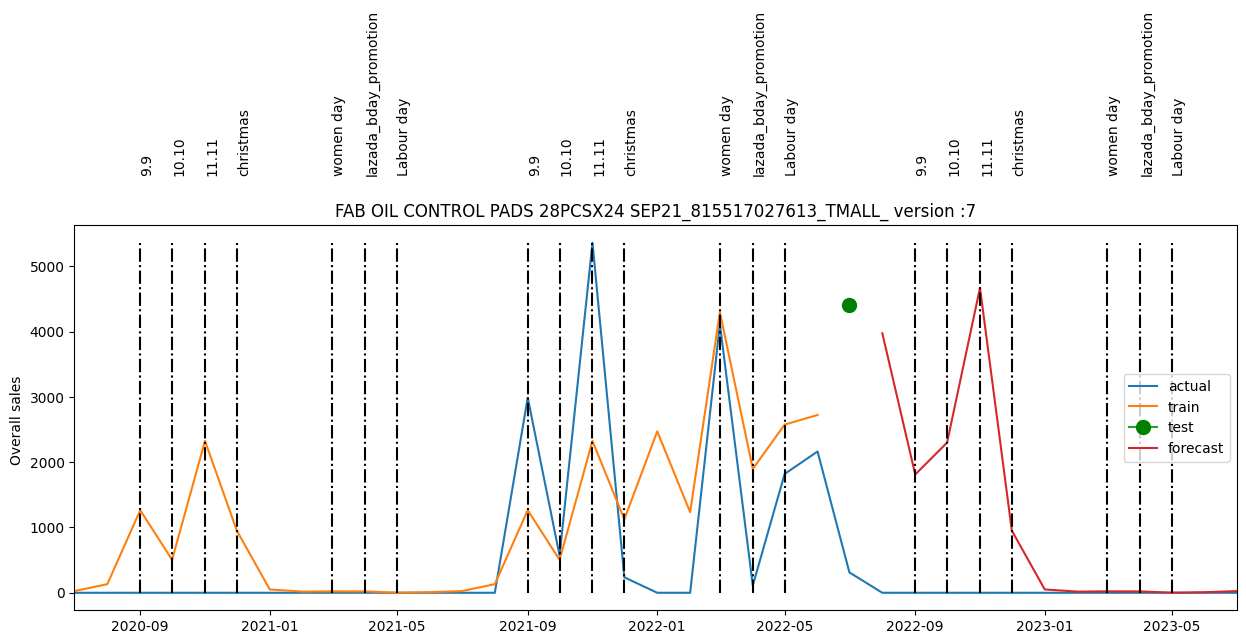

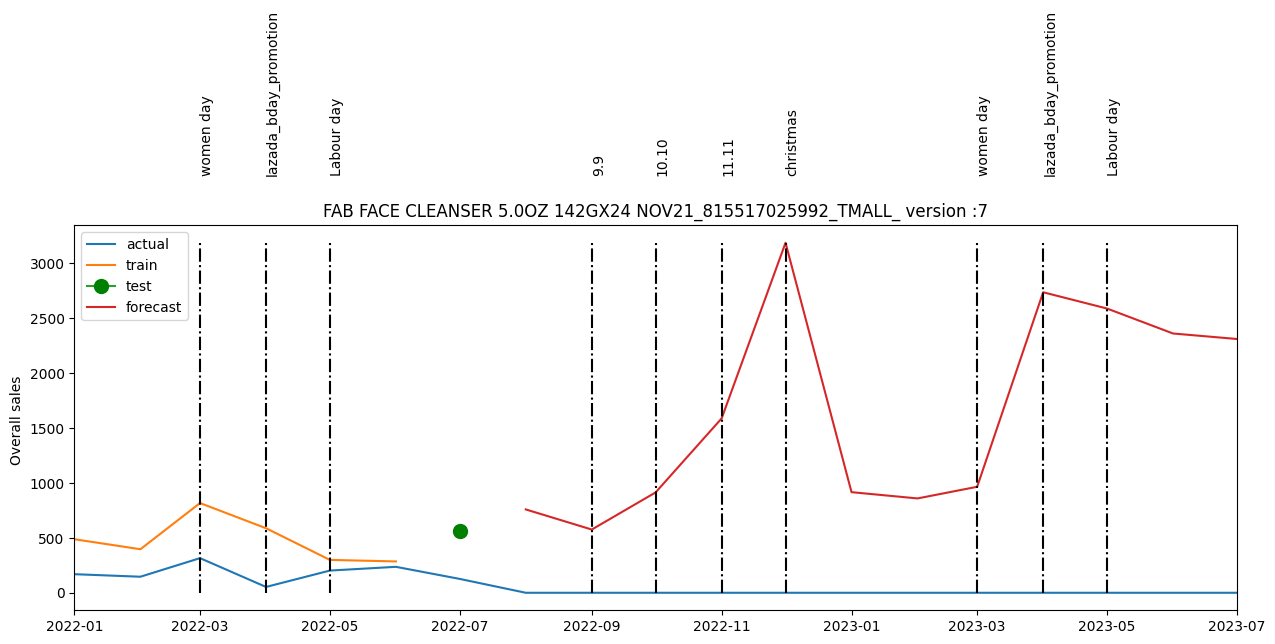

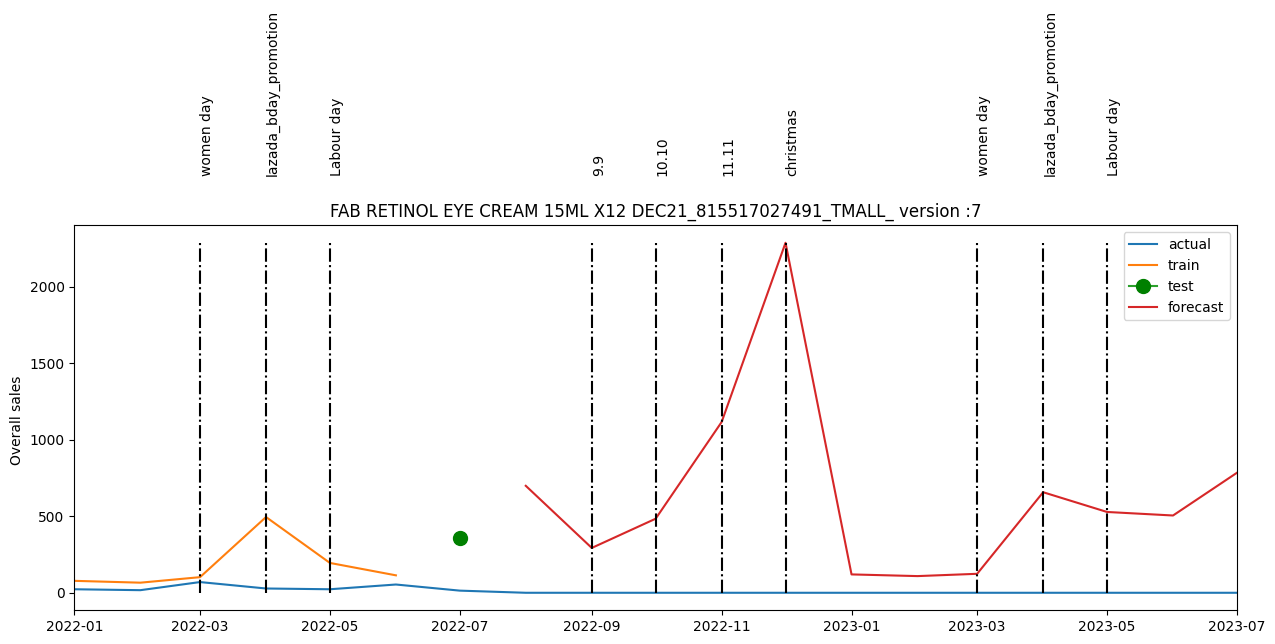

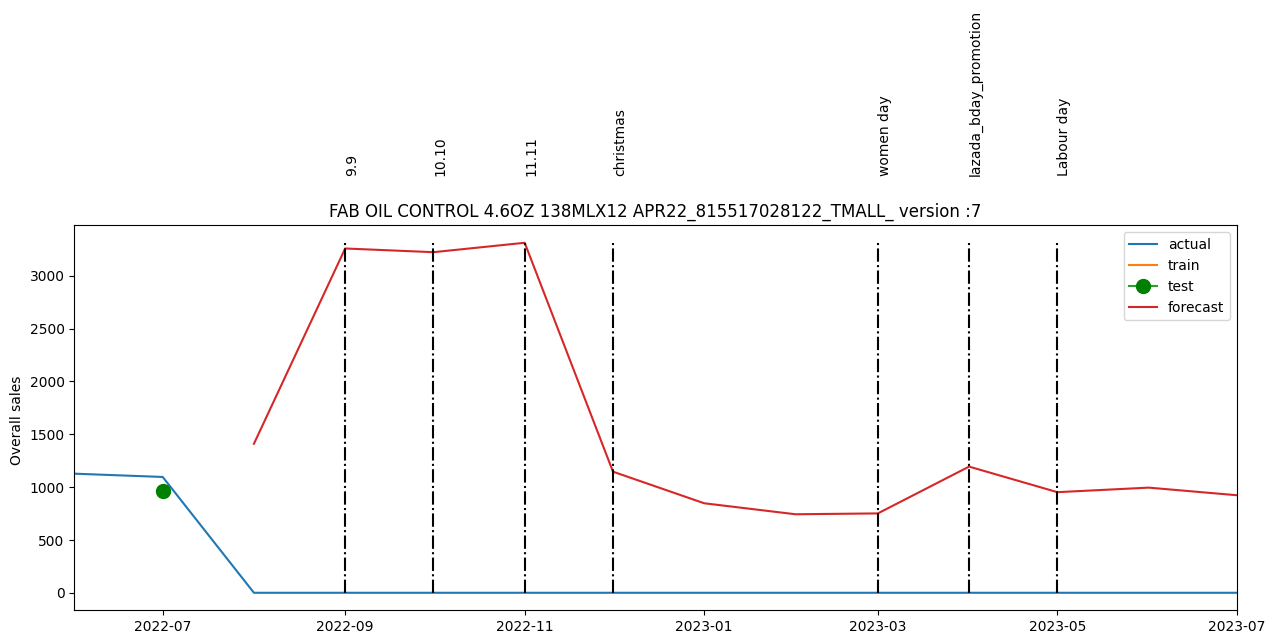

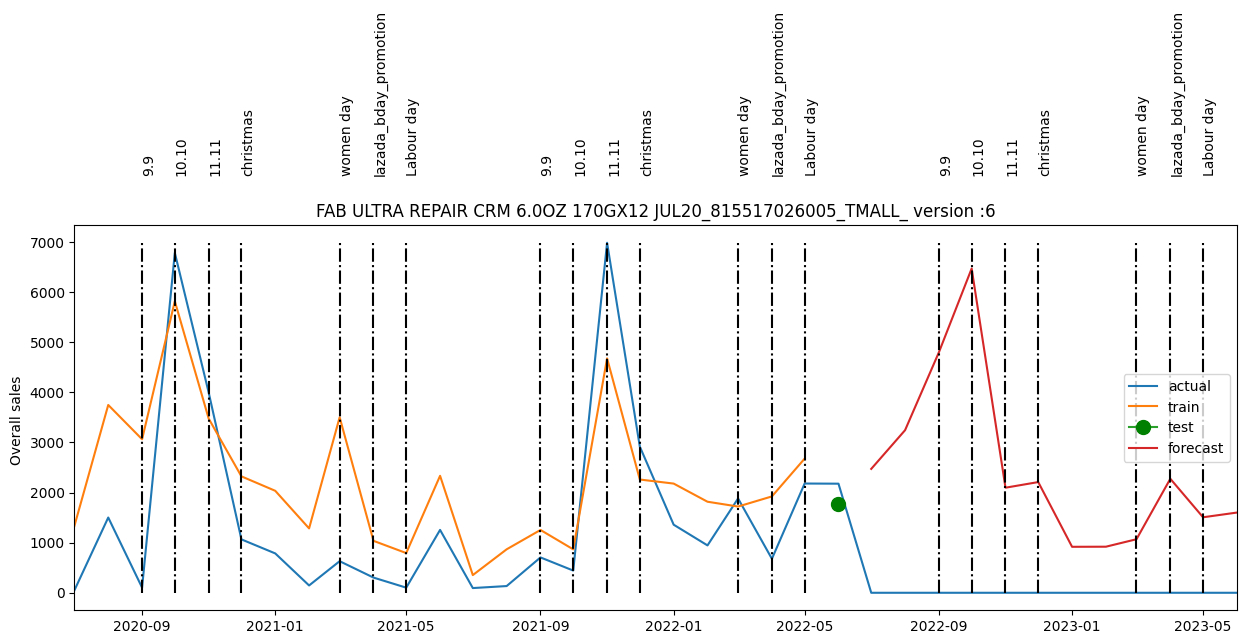

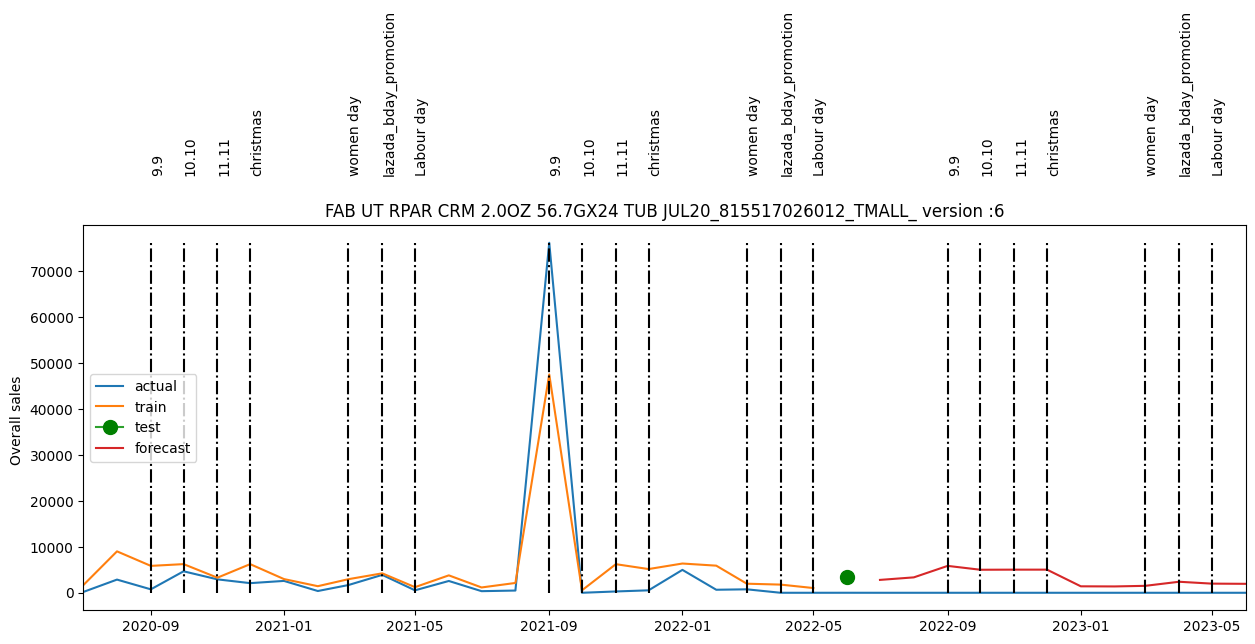

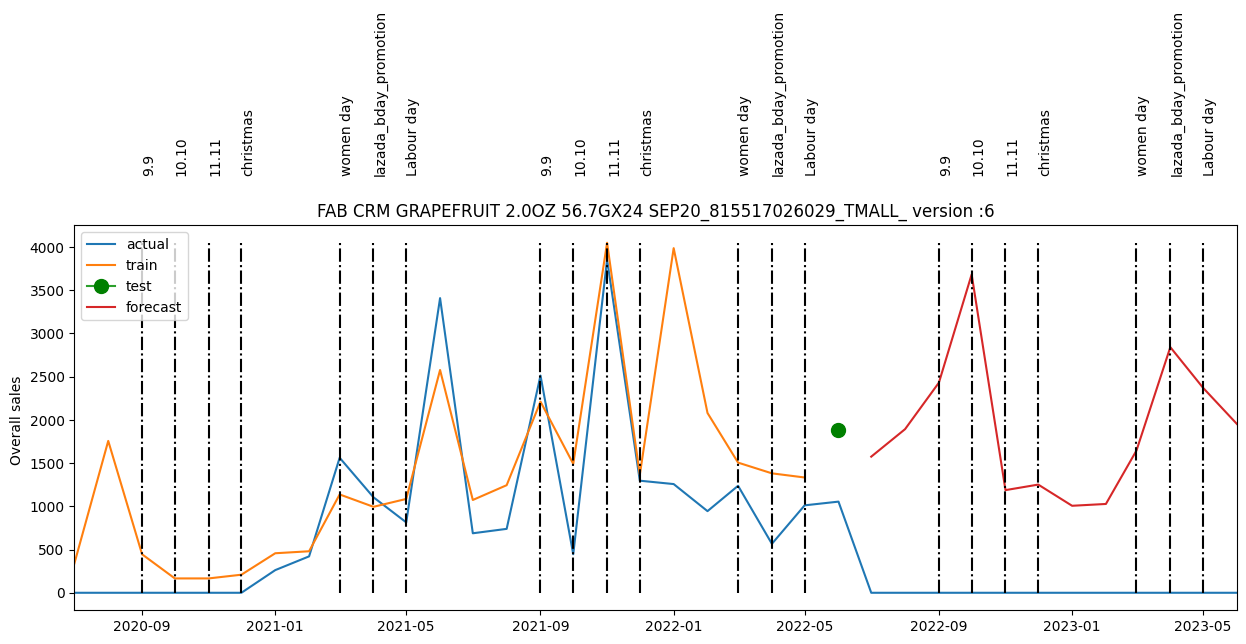

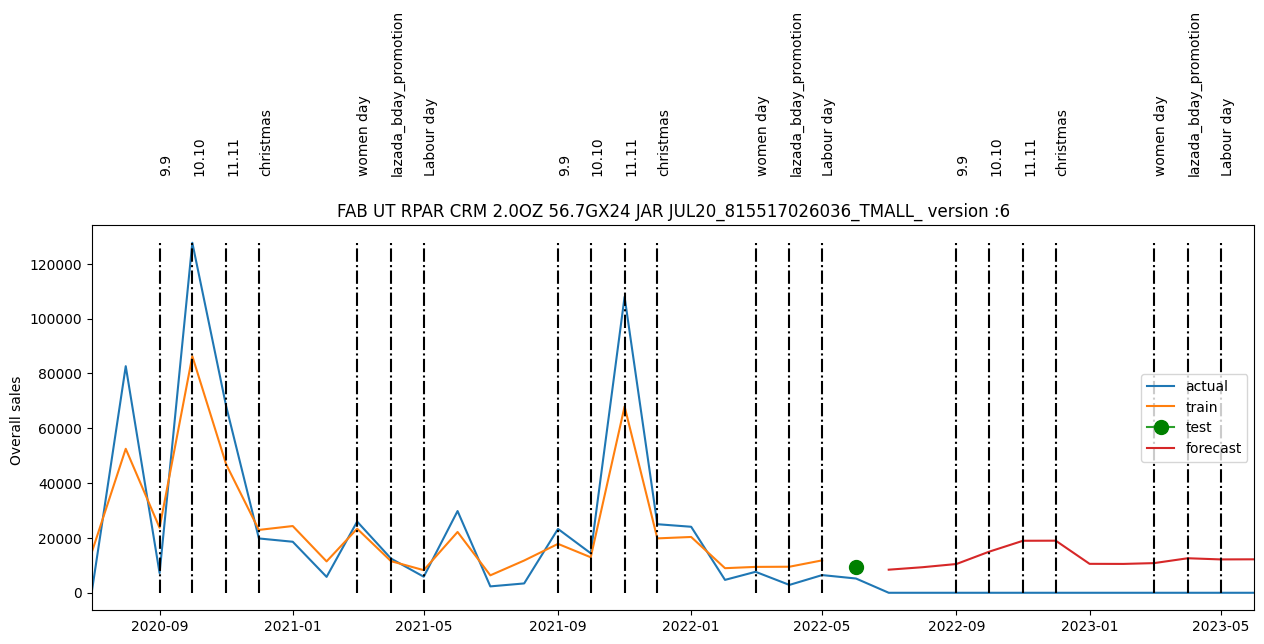

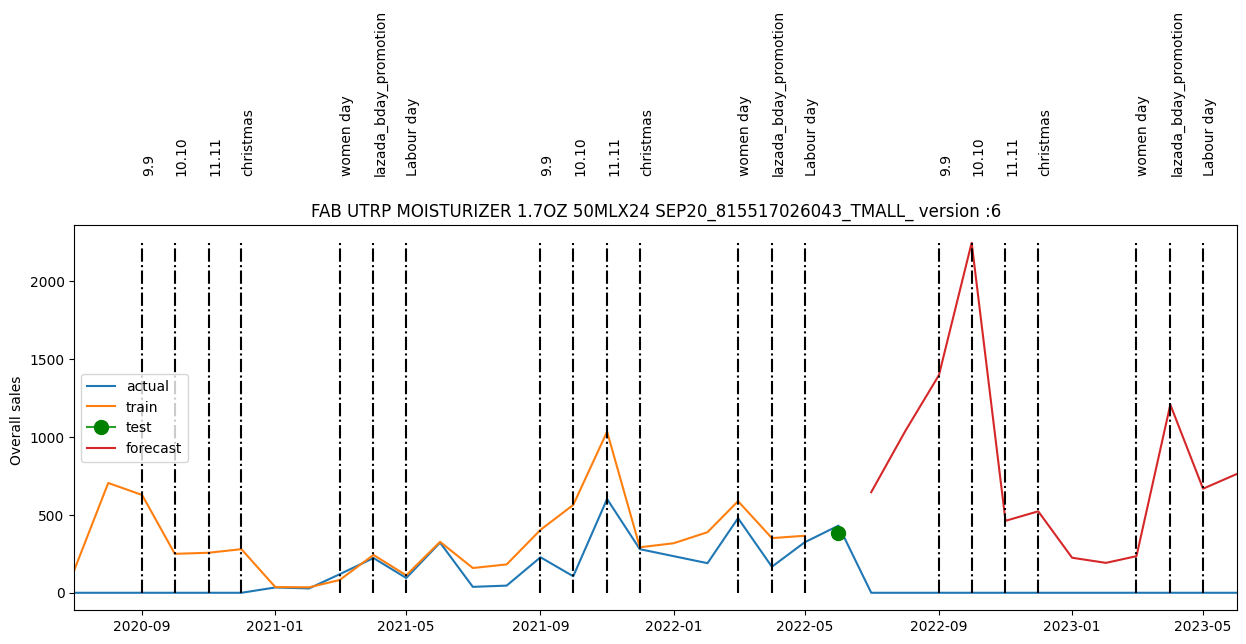

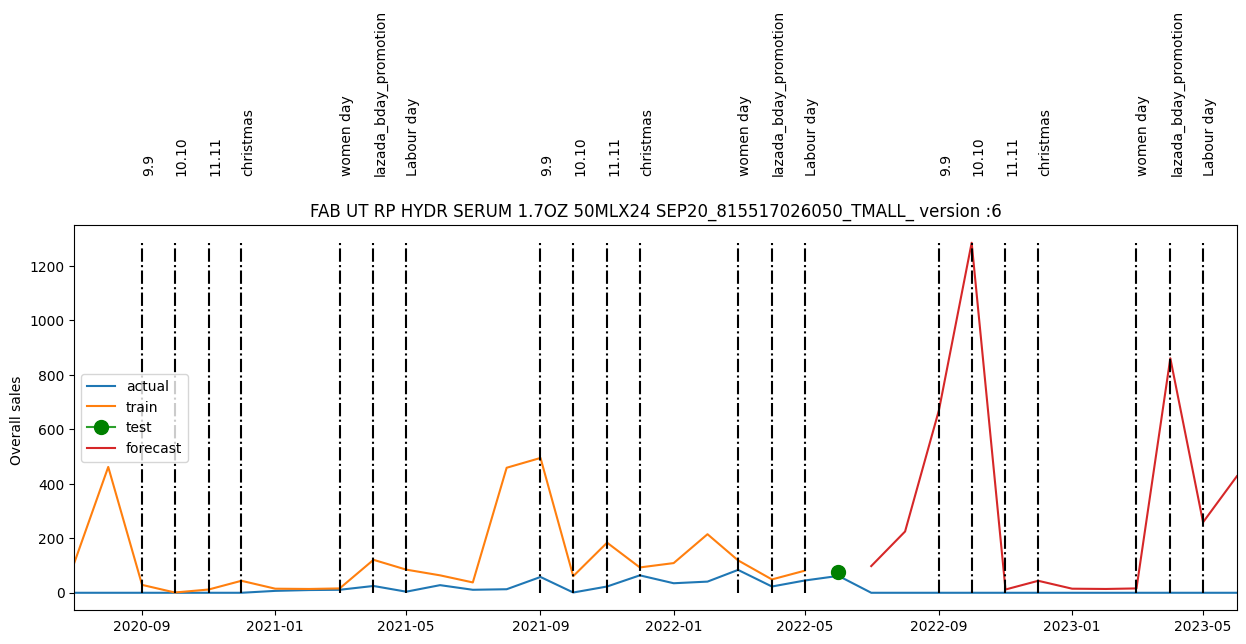

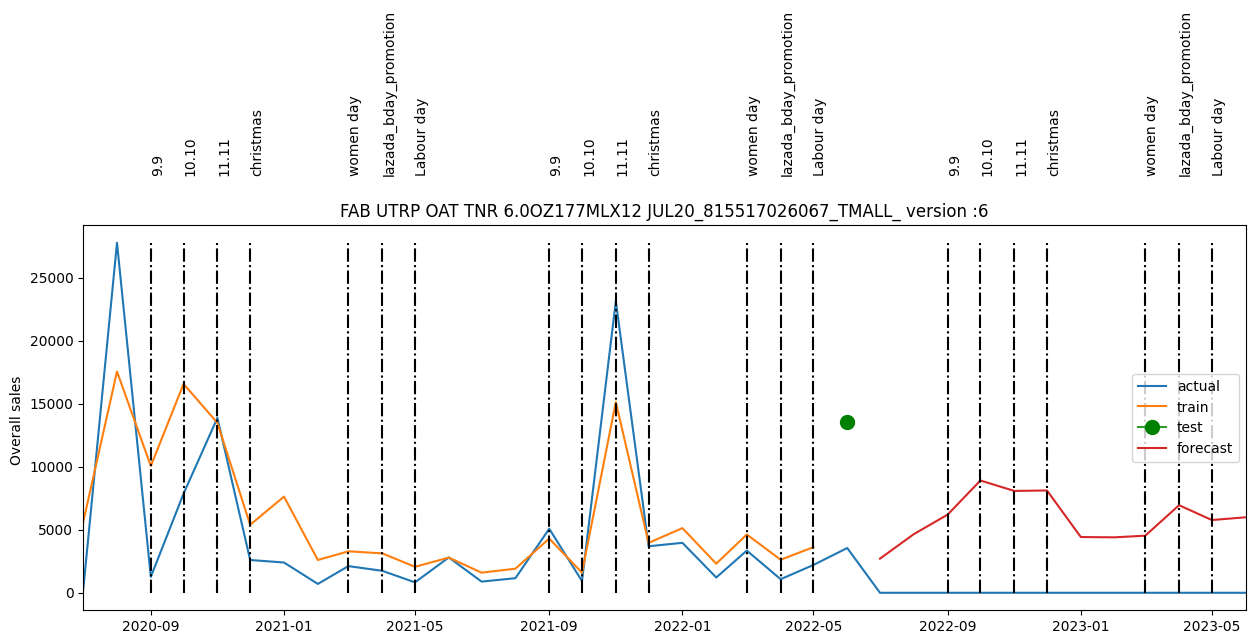

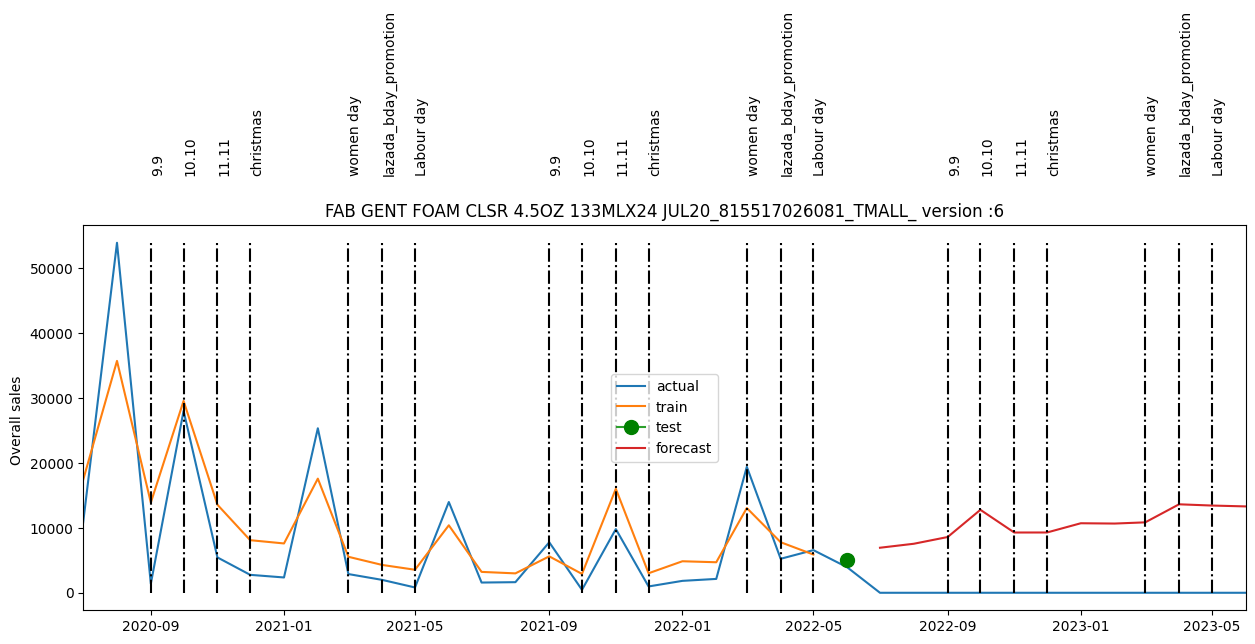

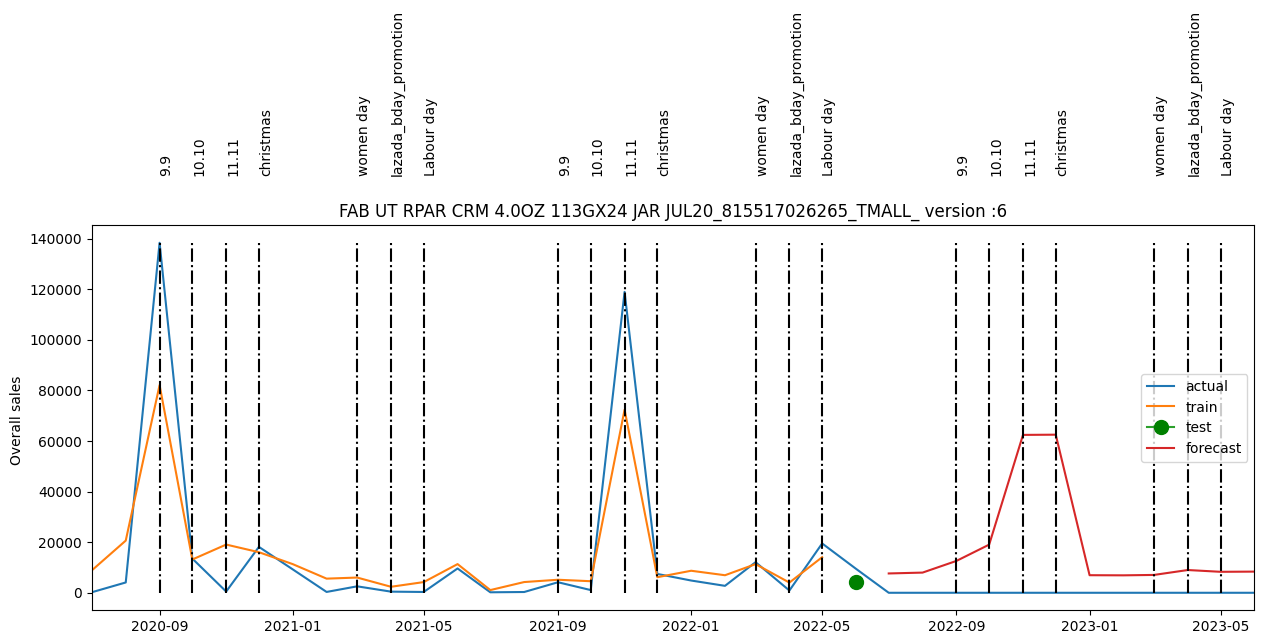

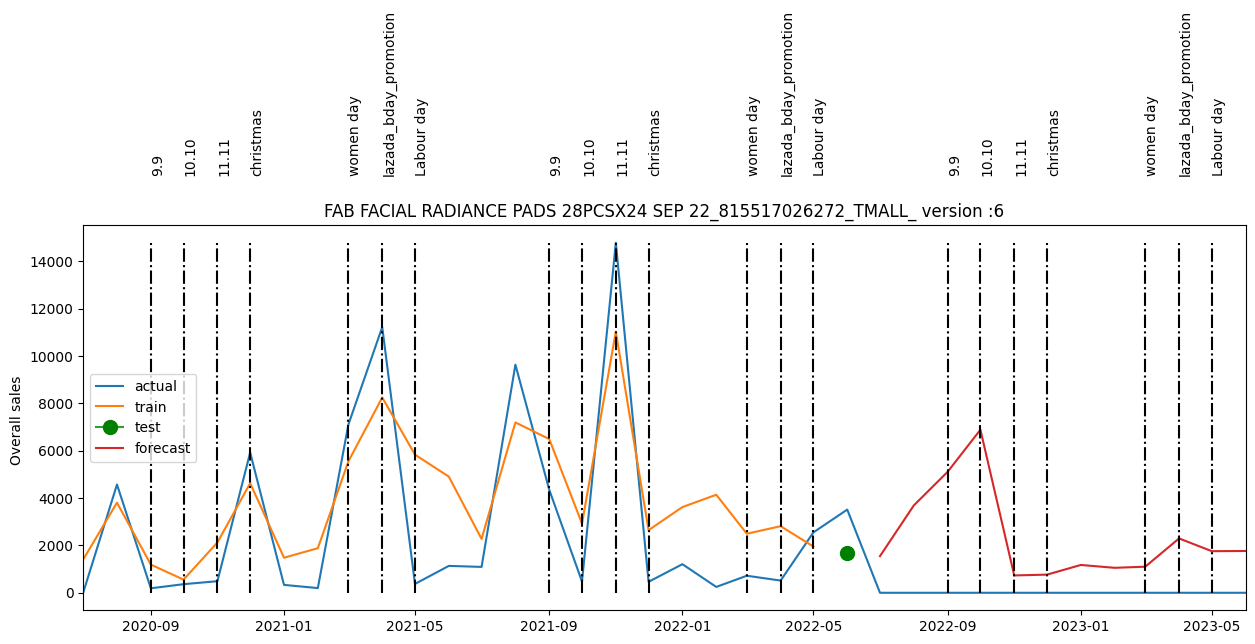

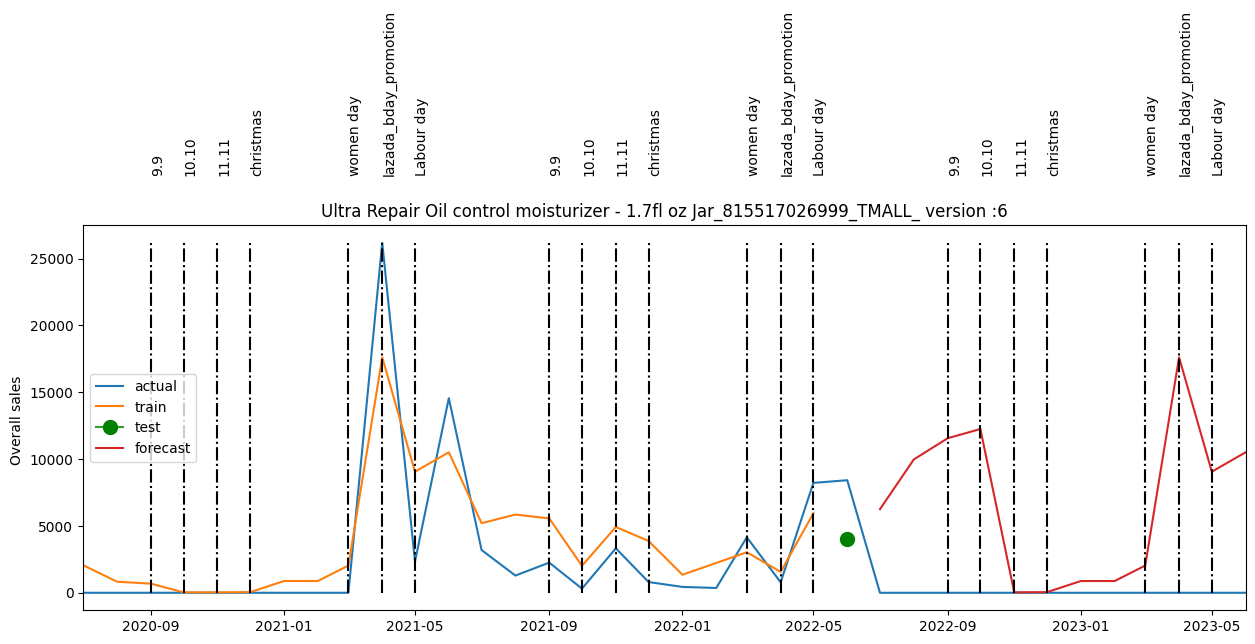

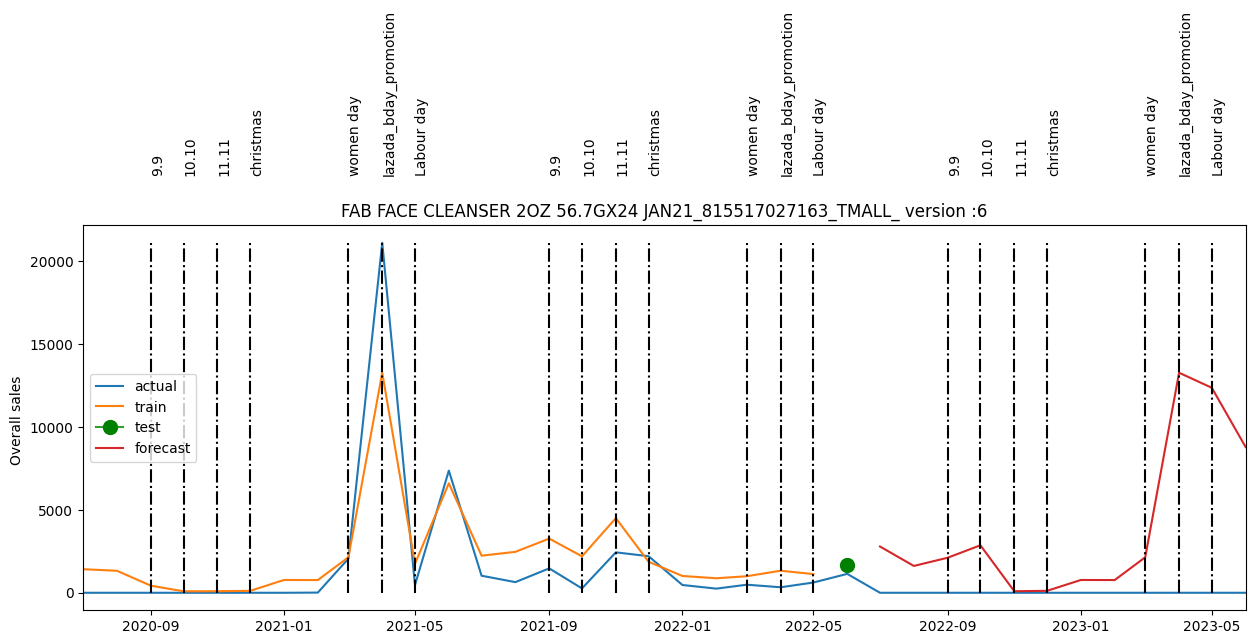

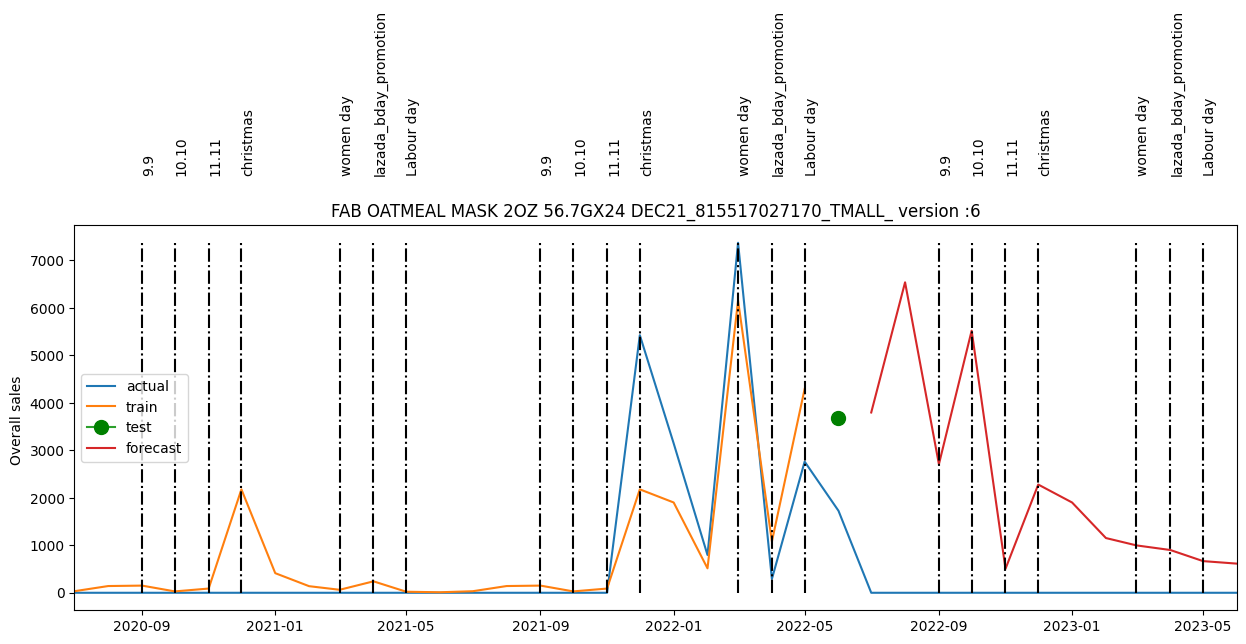

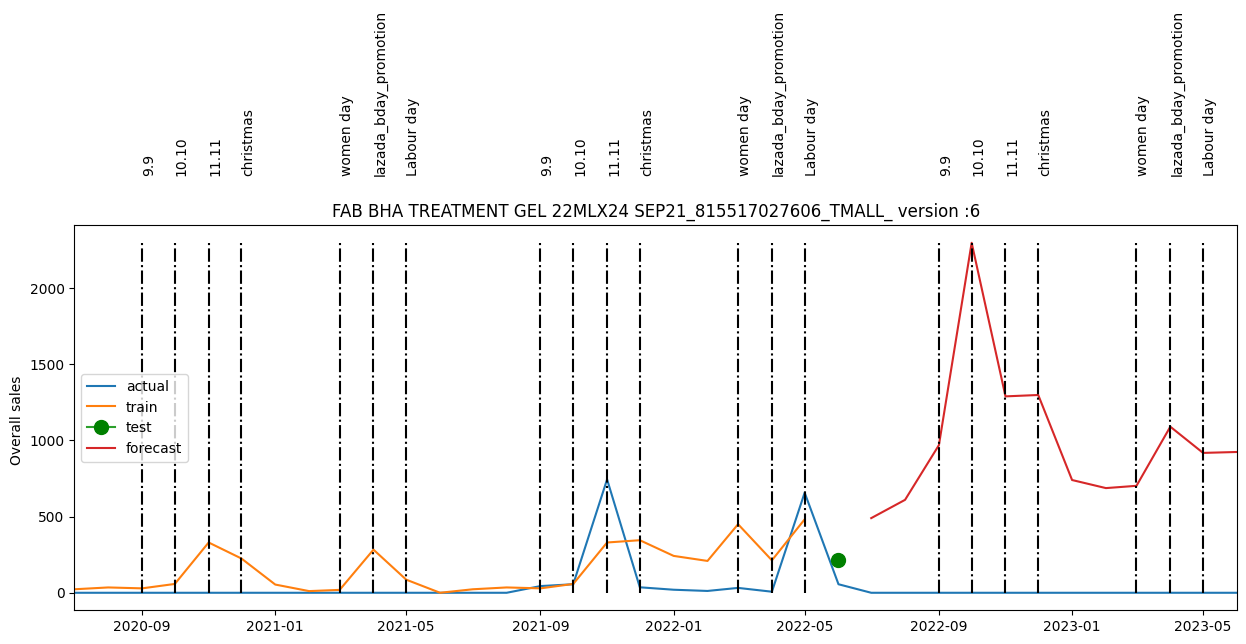

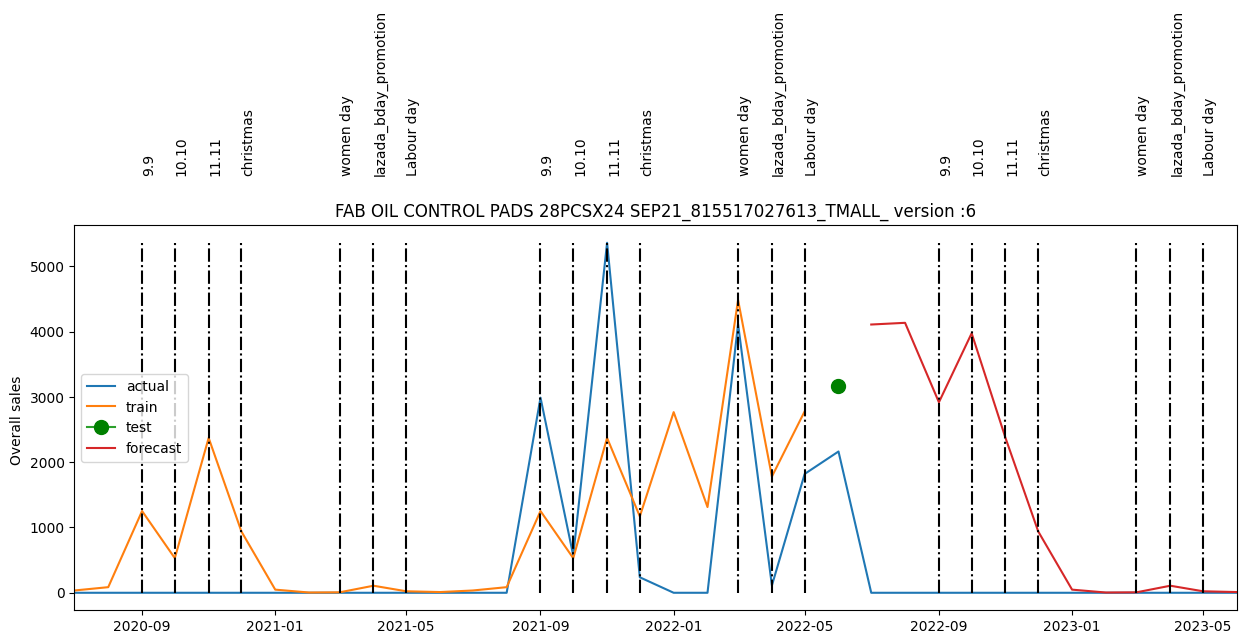

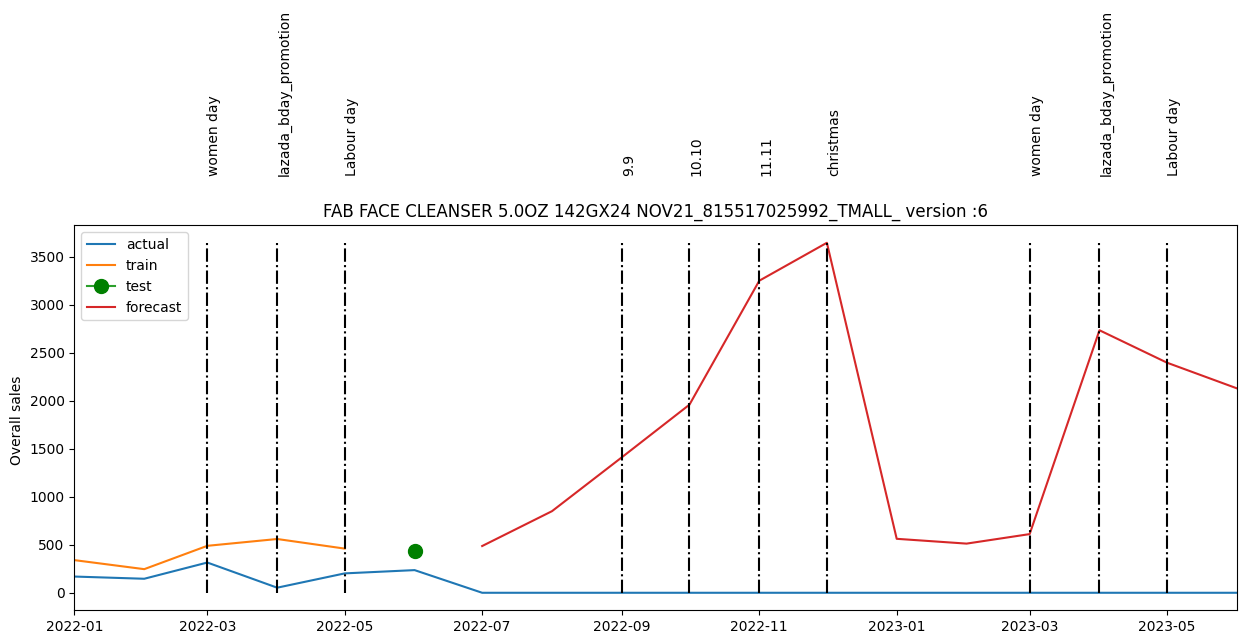

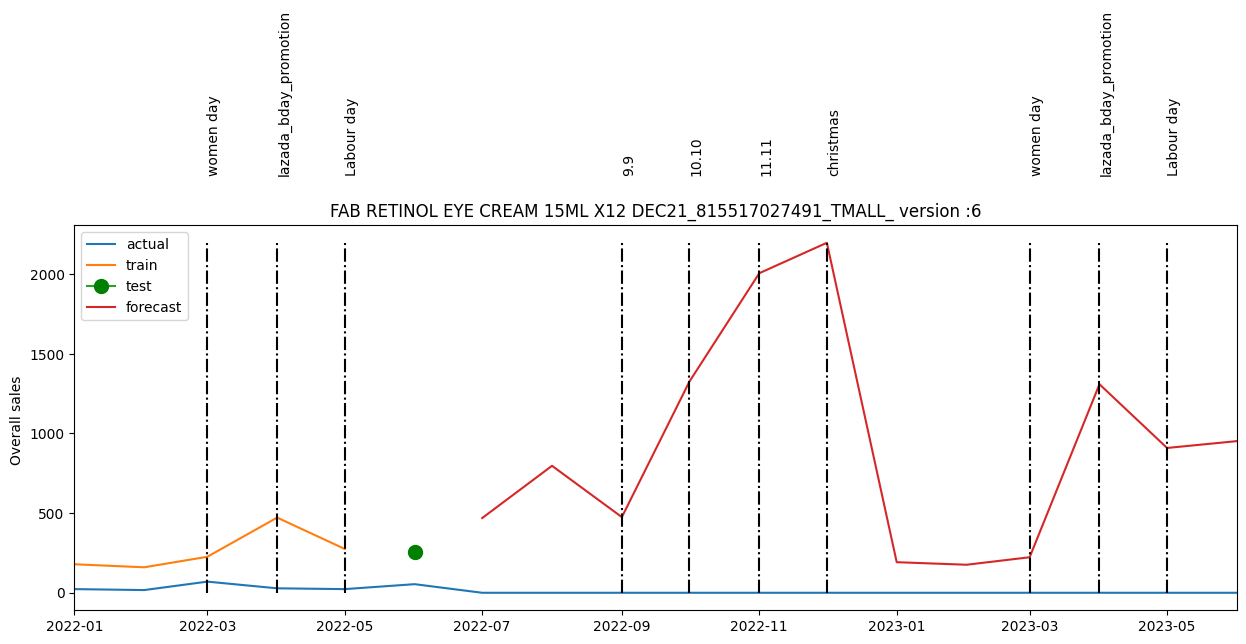

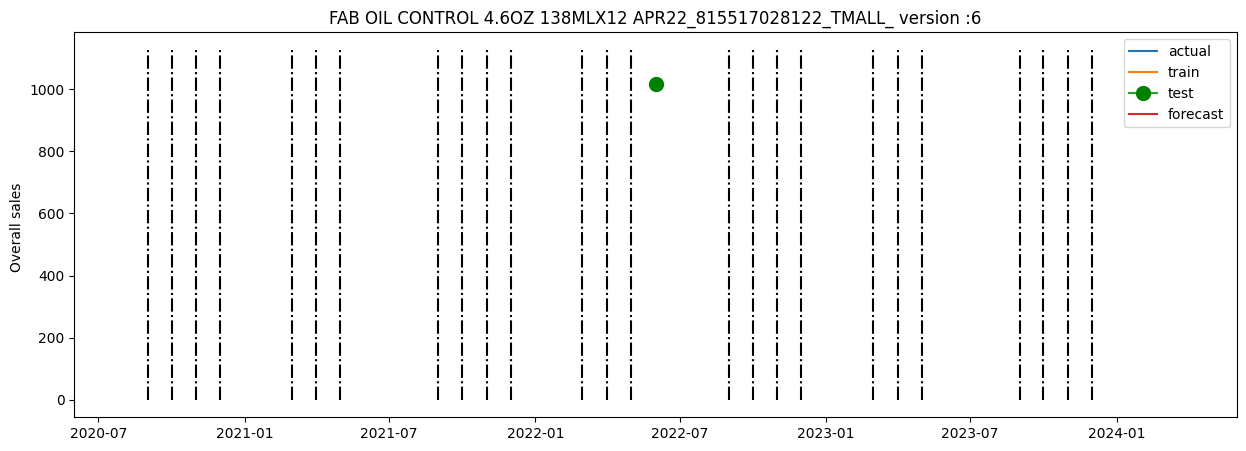

In [39]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['sku'].astype(str) + "_" + this_predict['customer']
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc + "_" + this_sku_cust + "_ version :" + str(versions[i]))
        plt.legend()
        plt.show()

In [40]:
results[ (results['sku'] == 815517026272)]

id           sku customer  version test_start   test_end  total_actual  total_forecast    rmse     mae     smape      mape     maape       sp1               model
9    9  815517026272    TMALL        8 2022-08-01 2022-08-01        3112.0          4171.0  1059.0  1059.0  0.290814  0.340296  0.328003  0.746104  Model per customer
27   9  815517026272    TMALL        7 2022-07-01 2022-07-01         672.0          1811.0  1139.0  1139.0  0.917439  1.694940  1.037769  0.371066  Model per customer
45   9  815517026272    TMALL        6 2022-06-01 2022-06-01        3511.0          1695.0  1816.0  1816.0  0.697657  0.517232  0.477338  2.071386  Model per customer

In [41]:
results = pd.DataFrame()
for i in range(len(versions)):
    this_version = versions[i]
    this_ts = predict_df.loc[(predict_df["version"] == this_version) ].reset_index(drop=True)
    for _id in this_ts.id.unique():
        ts = this_ts.loc[(this_ts["id"] == _id) ].reset_index(drop=True)
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"]) | ts.ts.isin(all_dates[versions[i]]["val"])].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "version":this_version,
            "id": _id,
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": all_dates[versions[i]]["val"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["version", "id", "sku", "customer", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]
results


KeyError: 'val'

In [ ]:
results_att = results.copy()
results_att.drop(columns={'id'},inplace=True)
print(results_att.shape)
print(att_df.columns)
att_df1 = att_df[['cases', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku', 'sku_description', 'uom']].drop_duplicates()
print(results_att.shape)
results_att = pd.merge(results_att,att_df1,on=['sku','customer'])
print(results_att.shape)
results_att.head()

In [ ]:
results_att[ (results_att['version'] == 8) & results_att

In [ ]:
att_df1[att_df1['sku'] == 815517026005]

In [ ]:


ts = predict_df.copy()
test_res = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"]) | ts.ts.isin(all_dates[versions[i]]["test"])].copy().reset_index(drop=True)
main_cols = ["version", "id", "sku", "customer", "ts", "y", "yhat"]
test_res.rename(columns={'y':'total_actual','yhat':'total_forecast'},inplace=True)
test_res = test_res[["version", "id", "ts", "sku", "customer","total_actual", "total_forecast"]]
test_res["sp1"] = test_res["total_actual"] / test_res["total_forecast"]
test_res["sp1"] = np.nan_to_num(test_res["sp1"], nan=1, posinf=0, neginf=0)
print(test_res.shape)
test_res = pd.merge(test_res,att_df1,on=['sku','customer'])
print(test_res.shape)
test_res.head()

In [ ]:
att_main = pd.read_excel('Attribute_and_data_points.xlsx', sheet_name='Attributes_China')
att_main.rename(columns={'SKU Description':'sku_description','Level2':'ph_level2','sku type':'item_type','units':'uom'},inplace=True)
att_main['ph_level3'] = 'FAB'
att_main = att_main[['sku','shortname']]
att_main                

In [ ]:
results_att = pd.merge(results_att,att_main,on='sku')
test_res = pd.merge(test_res,att_main,on='sku')
test_res['sp1'] = test_res['sp1'].round(2)
results_att['sp1'] = results_att['sp1'].round(2)

In [ ]:
import write_data_table
write_data_table.send_data(results_att,'sp1_china','w7')
write_data_table.send_data(test_res,'sp1_detail_china','w7')


In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['sku'].astype(str) + "_" + this_predict['customer']
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc + "_" + this_sku_cust)
        plt.legend()
        plt.show()

In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    skus =  this_predict.sku.unique()
    for this_sku in skus :
        this_ts = this_predict[this_predict['sku'] == this_sku]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc)
        plt.legend()
        plt.show()

In [ ]:
dc_offtake = pd.read_csv("offtake_china.csv")
print(dc_offtake.shape)
dc_offtake = dc_offtake[['sku','customer','warehouse','offtake_percent_dc']].drop_duplicates()
print(dc_offtake.shape)
dc_offtake.head()

In [ ]:
dc_offtake[dc_offtake['sku'] == 815517025992]

In [ ]:
predict_df_dc = predict_df[['ts','sku','customer', 'yhat', 'y']]
print(predict_df_dc.shape)
predict_df_dc = pd.merge(predict_df_dc,dc_offtake,on=['sku','customer'],how='left')
print(predict_df_dc.shape)
predict_df_dc['yhat_dc'] = predict_df_dc['yhat']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['yhat_dc'] = predict_df_dc['yhat_dc'].astype('int64')
predict_df_dc['y_dc'] = predict_df_dc['y']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['y_dc'].fillna(0,inplace=True)
predict_df_dc['y_dc'] = predict_df_dc['y_dc'].astype('int64')
predict_df_dc

In [ ]:
att_df_main = att_df[['id','sku','customer','warehouse']]
predict_df_dc_final = pd.merge(predict_df_dc,att_df_main,on=['sku','customer','warehouse'],how='left')
predict_df_dc_final.head()

In [ ]:
replenishment_op = predict_df_dc_final.copy()
replenishment_op.rename(columns={'y_dc':'demand'},inplace=True)
replenishment_op.drop(columns={'offtake_percent_dc','id'},inplace=True)
replenishment_op["ts"] = pd.to_datetime(replenishment_op["ts"])
replenishment_op['type'] = 'Actuals'
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'type'] = 'Forecast'
replenishment_op = replenishment_op[['ts','sku','customer','warehouse','demand','yhat_dc']]
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'demand'] = replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'yhat_dc'] 
replenishment_op.drop(columns={'yhat_dc'},inplace=True)
replenishment_op.head()

In [ ]:
replenishment_op.to_csv("actuals_forecast_china.csv")

In [ ]:
predict_df["ts"] = predict_df["ts"].astype("datetime64[ns]")
predict_df["id"] = predict_df["id"].astype("uint64")
predict_df["y"] = predict_df["y"].astype("float64")

val_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-2:-1])].reset_index(drop=True)
test_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-1:])].reset_index(drop=True)
predict_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['forecast'])].reset_index(drop=True)
val_df = val_df[["ts", "id", "yhat"]].copy()
val_df.rename(columns={"yhat": "y"}, inplace=True)
predict_df = predict_df[["ts", "id", "yhat"]].copy()
predict_df.rename(columns={"yhat": "y"}, inplace=True)
test_df = test_df[["ts", "id", "yhat"]].copy()
test_df.rename(columns={"yhat": "y"}, inplace=True)

valid_df = lambda df : all([x in df.columns for x in ['ts', 'id', 'y']])


In [ ]:

## Validate df structure
if not valid_df(val_df):
    raise ValueError("Validate Dataframe columns are not compliant")
    
## Test df structure
if not valid_df(test_df):
    raise ValueError("Test Dataframe columns are not compliant")
    
## Predict df structure
if not valid_df(predict_df):
    raise ValueError("Predict Dataframe columns are not compliant")
    
def save_parquet(data, file_path, index=None):
    data = data[['ts', 'id', 'y']]
    mapping = {c: str for c in data.columns if data[c].dtype == object}
    data.astype(mapping).to_parquet(file_path, index=index)
    return file_path

# replace df below with dataframe with test and prediction outputs
predict_ts_path = save_parquet(predict_df, predict_ts_path, False)
test_ts_path = save_parquet(val_df, test_ts_path, False)
validate_ts_path = save_parquet(test_df, validate_ts_path, False)